In [1]:
import mne
import os
import scipy.io
import listen_italian_functions
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib as mpl
from mne.stats import permutation_cluster_test
from mne.stats import permutation_cluster_1samp_test
from functools import partial
from mne.stats import ttest_1samp_no_p, permutation_t_test,fdr_correction,spatio_temporal_cluster_1samp_test
from IPython.display import clear_output
from itertools import permutations,combinations
#sns.set(style="darkgrid")
sns.set(font_scale=1.5)
from joblib import Parallel, delayed
from scipy import stats

data_path = os.path.dirname(os.getcwd())

subject_name = ['Alice','Andrea','Daniel','Elena','Elenora','Elisa','Federica','Francesca','Gianluca1','Giada','Giorgia',
                'Jonluca','Laura','Leonardo','Linda','Lucrezia','Manu','Marco','Martina','Pagani','Pasquale','Sara',
                'Silvia','Silvia2','Tommaso']


trial_len = 2
remove_first = 0.5 #seconds

save_path = data_path + '/data/coherence'

info = mne.io.read_raw_fif((save_path+'-info'),preload=True)


Opening raw data file D:\projects\current\listen_italian_motor_entrainment\analysis\python\data\coherence-info...
This filename (D:\projects\current\listen_italian_motor_entrainment\analysis\python\data\coherence-info) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
    Range : 40502 ... 1132918 =     40.502 ...  1132.918 secs
Ready.
Reading 0 ... 1092416  =      0.000 ...  1092.416 secs...


In [2]:
# frequency range seletion
freq=np.arange(1,40,0.5)
fr_smooth = 1/(2*(3/freq))
F = []
for f in range(0,len(freq)):
    F.append((freq[f]-fr_smooth[f],freq[f]+fr_smooth[f],freq[f],fr_smooth[f]))
    
F = np.asarray(F)  
F

array([[ 0.83333333,  1.16666667,  1.        ,  0.16666667],
       [ 1.25      ,  1.75      ,  1.5       ,  0.25      ],
       [ 1.66666667,  2.33333333,  2.        ,  0.33333333],
       [ 2.08333333,  2.91666667,  2.5       ,  0.41666667],
       [ 2.5       ,  3.5       ,  3.        ,  0.5       ],
       [ 2.91666667,  4.08333333,  3.5       ,  0.58333333],
       [ 3.33333333,  4.66666667,  4.        ,  0.66666667],
       [ 3.75      ,  5.25      ,  4.5       ,  0.75      ],
       [ 4.16666667,  5.83333333,  5.        ,  0.83333333],
       [ 4.58333333,  6.41666667,  5.5       ,  0.91666667],
       [ 5.        ,  7.        ,  6.        ,  1.        ],
       [ 5.41666667,  7.58333333,  6.5       ,  1.08333333],
       [ 5.83333333,  8.16666667,  7.        ,  1.16666667],
       [ 6.25      ,  8.75      ,  7.5       ,  1.25      ],
       [ 6.66666667,  9.33333333,  8.        ,  1.33333333],
       [ 7.08333333,  9.91666667,  8.5       ,  1.41666667],
       [ 7.5       , 10.

Text(0.5,1,'Coherence between speech envelop and lipaparature')

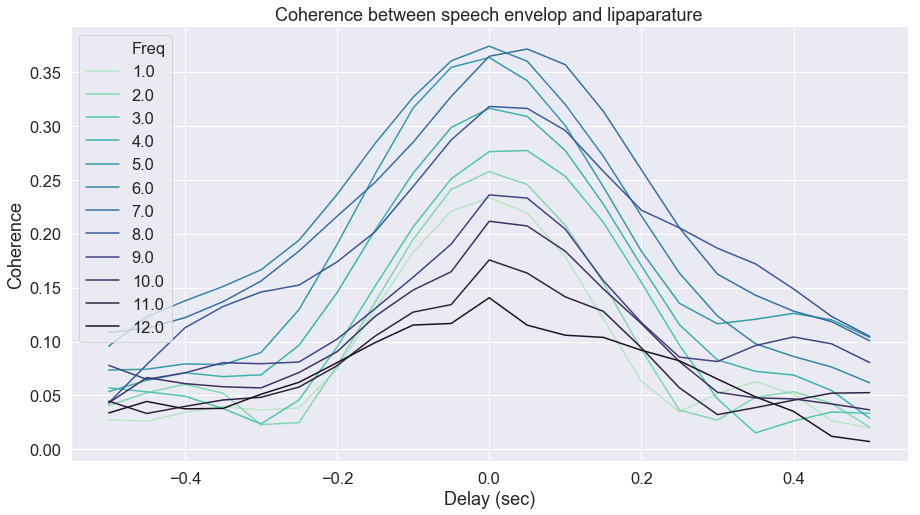

In [44]:
# coherence beteewn stimuli in delay
save_path = data_path + '/data/coherence/Coh-removedFirst-0.5-2_envelop-'+ \
                    'EMA_trial_normalized_coh-multitaper3cycle-1-40.5Hz-0.5step.pkl'

data=pd.read_pickle(save_path)

a  = data['Data'].apply(lambda x: np.mean(x))
data['Coherence'] = pd.Series(a, index=data.index)
data.set_index(['Feature','Freq','Condition','Delay','Subject'], inplace=True)
data.sort_index(inplace=True)

freq =  [ '1 - 4 Hz','4 - 8 Hz','8 - 12 Hz']
freq_band = np.arange(1,13,1)

features = ['lipaparature']

delay = np.arange(-5,6) / 10
delay = np.arange(-5,5.5,0.5) / 10

condition = ['All']
#condition = ['normal']

a = data.loc[features,freq_band,condition,delay,'aa']['Coherence']
a = a.reset_index()

f, ax = plt.subplots(figsize=(15,8))
sns.lineplot(data=a,x="Delay", y="Coherence",hue="Freq",palette=sns.color_palette("mako_r", freq_band.shape[0]))

plt.xlabel('Delay (sec)')
plt.ylabel('Coherence')
#b.fig.legend(freq_band,loc=1)

plt.title('Coherence between speech envelop and ' +features[0])

Text(0.5,1,'Coherence between speech envelop and lipaparature at 0 dealy')

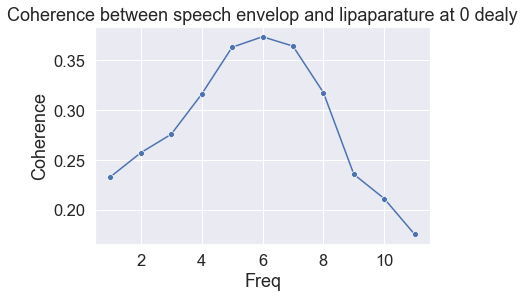

In [51]:
freq_band = np.arange(1,12,1)
delay =0

features = ['lipaparature']
a = data.loc[features,freq_band,condition,delay,'aa']['Coherence'].reset_index()

f, ax = plt.subplots(figsize=(6,4))

sns.lineplot(data=a,x='Freq',y='Coherence',marker='o')
plt.title('Coherence between speech envelop and ' +features[0]+ ' at 0 dealy')

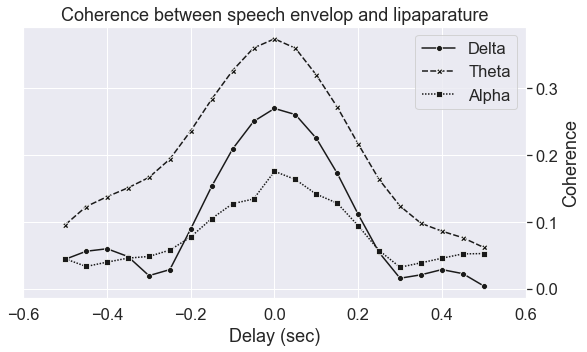

In [19]:
f, ax = plt.subplots(figsize=(9,5))
freq =  [ 'Delta','Theta','Alpha']

sns.lineplot(x="Delay", y="Coherence",style="Freq", markers=True,color='k',data=a)
plt.xlabel('Delay (sec)')
plt.ylabel('Coherence')
plt.legend(freq,loc=1)
plt.title('Coherence between speech envelop and ' +features[0])
plt.xlim([-0.6,0.6])
ax.yaxis.tick_right()

ax.yaxis.set_label_position("right")


In [59]:
# data coherence
# frequency estimation with 1hz step
save_path = data_path + '/data/coherence/coh-multitaper3cycle-1-40.5Hz-0.5step.pkl'
#save_path = data_path + '/data/coherence/coh-multitaper3cycle-1-40.5Hz-0.5step-adaptiveFalse_normal.pkl'
#save_path = data_path + '/data/coherence/coh-multitaper3cycle-1-40.5Hz-0.5step-adaptiveFalse_hyper.pkl'
#save_path = data_path + '/data/coherence/coh-multitaper3cycle-1-40.5Hz-0.5step-adaptiveFalse_hypo.pkl'
#save_path = data_path + '/data/coherence/Pcoh-eegtrialremove-removedFirst0.5.pkl'
save_path = data_path + '/data/coherence/coh-multitaper3cycle-1-40.5Hz-0.5step_envelop_increase_additinalSegments.pkl'
#save_path = data_path + '/data/coherence/coh-fourier-1-40.5Hz-0.5step_additinalSegments.pkl'
save_path = data_path + '/data/coherence/coherence_multitaper_wholeTrial_withdelay.pkl'
save_path = data_path + '/data/coherence/bandwidth_1_1-5hz.pkl'
save_path = data_path + '/data/coherence/bandwidth_4_1-5hz.pkl'
save_path = data_path + '/data/coherence/bandwidth_3_1-5hz.pkl'
save_path = data_path + '/data/coherence/bandwidth_2_1-5hz.pkl'
save_path = data_path + '/data/coherence/bandwidth_0.5_1-5hz.pkl'
save_path = data_path + '/data/coherence/coh-fourier-1-40.5Hz-0.5step_additinalSegments_averageFreq.pkl'
save_path = data_path + '/data/coherence/coh-multitaper3cycle-1-40.5Hz-0.5step_additinalSegments_averageFreq.pkl'
save_path = data_path + '/data/coherence/bandwidth_1.5_1-5hz.pkl'
save_path = data_path + '/data/coherence/coh-multitaper_1.5hz-threeBands_averageFreq.pkl'
save_path = data_path + '/data/coherence/bandwidth_3.5_1-5hz.pkl'
save_path = data_path + '/data/coherence/bandwidth_1.2_1-15hz.pkl'
save_path = data_path + '/data/coherence/bandwidth_2_1-15hz.pkl'
save_path = data_path + '/data/coherence/bandwidth_3.6_1-10hz.pkl'

data=pd.read_pickle(save_path)

a  = data['Data'].apply(lambda x: np.arctanh(x))
#b  = data['noTrials'].apply(lambda x: 1/(2*x-2))
#data['Data'] = pd.Series(a-b, index=data.index)

a  = data['Data'].apply(lambda x: np.mean(x))
data['Coherence'] = pd.Series(a, index=data.index)
a = data.reset_index()
df = pd.DataFrame(np.column_stack(list(zip(*a.Data))), columns=info.ch_names)
data = pd.concat([a,df], axis=1)
data.set_index(['Feature','Freq','Condition','Delay','Subject'], inplace=True)
data.sort_index(inplace=True)




In [2]:
# data coherence merge data with jonluca and 1 hz
# frequency estimation with 1hz step
save_path = data_path + '/data/coherence/coh-multitaper3cycle-1-40.5Hz-0.5step.pkl'

data=pd.read_pickle(save_path)


a  = data['Data'].apply(lambda x: np.mean(x))
data['Coherence'] = pd.Series(a, index=data.index)
a = data.reset_index()
df = pd.DataFrame(np.column_stack(list(zip(*a.Data))), columns=info.ch_names)
data = pd.concat([a,df], axis=1)
data.set_index(['Feature','Freq','Condition','Delay','Subject'], inplace=True)
data.sort_index(inplace=True)

features = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']
condition = ['All']
fr = [2.5,6,11]
fr = np.arange(1.5,40,0.5)
delay = np.arange(-5,5.5,0.5) / 10

a = data.loc[features,fr,condition,delay,'Jonluca']
Jonluca = a.reset_index()

# 1 hz freq include
save_path = data_path + '/data/coherence/test_freq1_jonluca.pkl'
data=pd.read_pickle(save_path)
a  = data['Data'].apply(lambda x: np.mean(x))
data['Coherence'] = pd.Series(a, index=data.index)
a = data.reset_index()
df = pd.DataFrame(np.column_stack(list(zip(*a.Data))), columns=info.ch_names)
data = pd.concat([a,df], axis=1)
data.set_index(['Feature','Freq','Condition','Delay','Subject'], inplace=True)
data.sort_index(inplace=True)


features = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']
condition = ['All']
fr = [1]
delay = np.arange(-5,5.5,0.5) / 10

a = data.loc[features,fr,condition,delay,'Jonluca']
Jonluca_1hz = a.reset_index()



Jonluca = pd.concat([Jonluca, Jonluca_1hz])


###################

# data coherence
# 1 hz freq include
save_path = data_path + '/data/coherence/test_freq1.pkl'
data=pd.read_pickle(save_path)
a  = data['Data'].apply(lambda x: np.mean(x))
data['Coherence'] = pd.Series(a, index=data.index)
a = data.reset_index()
df = pd.DataFrame(np.column_stack(list(zip(*a.Data))), columns=info.ch_names)
data = pd.concat([a,df], axis=1)
data.set_index(['Feature','Freq','Condition','Delay','Subject'], inplace=True)
data.sort_index(inplace=True)

features = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']
condition = ['All']
fr = [1]
delay = np.arange(-5,5.5,0.5) / 10

a = data.loc[features,fr,condition,delay]
data_1hz = a.reset_index()


# frequency estimation with 1hz step
save_path = data_path + '/data/coherence/coh-multitaper3cycle-1-40.5Hz-0.5step_envelop_increase_additinalSegments.pkl'
save_path = data_path + '/data/coherence/coh-multitaper3cycle-1-40.5Hz-0.5step_additinalSegments.pkl'

data=pd.read_pickle(save_path)


a  = data['Data'].apply(lambda x: np.mean(x))
data['Coherence'] = pd.Series(a, index=data.index)
a = data.reset_index()
df = pd.DataFrame(np.column_stack(list(zip(*a.Data))), columns=info.ch_names)
data = pd.concat([a,df], axis=1)

DATA = pd.concat([data, data_1hz])


# merge data

data = pd.concat([DATA, Jonluca])
data.set_index(['Feature','Freq','Condition','Delay','Subject'], inplace=True)
data.sort_index(inplace=True)

In [2]:
# data coherence from fieldtrip
raw_fname = data_path + '/entrainment_python/coh_fieldtrip_1.5hzsmooth_0.5-15.mat'
raw_fname = data_path + '/entrainment_python/coh_fieldtrip_2hzsmooth_0.5-15.mat'
raw_fname = data_path + '/entrainment_python/coh_fieldtrip_1.5hzsmoothDPSS_0.5-5.mat'
raw_fname = data_path + '/entrainment_python/coh_fieldtrip_freqdeptsmoothDPSS_0.5-15.mat'

mat = scipy.io.loadmat(raw_fname)

#speech = mat['behaviour']['speech'][0][0]
envelop = mat['envelop']
lip = mat['lip']
freqs = mat['freq'][0]
freqs = np.arange(0.5,15.5,0.5)

delay = np.arange(-5,5.5,0.5) / 10
con = 'All'
frames=[]
for s in range(0,len(subject_name)):
    for d in range(0,len(delay)):        
        for fr in range(0,len(freqs)):
            df = pd.DataFrame({'Condition':con,'Freq':freqs[fr],'Delay':delay[d],'Subject':subject_name[s],
                               'Feature':'envelop','Data':[envelop[s,:,fr,d]]})
            frames.append(df) 

            df = pd.DataFrame({'Condition':con,'Freq':freqs[fr],'Delay':delay[d],'Subject':subject_name[s],
                               'Feature':'lipaparature','Data':[lip[s,:,fr,d]]})
            frames.append(df) 
    print(str(d)+'-'+subject_name[s])
clear_output()    
data=pd.concat((frames),axis=0)
a  = data['Data'].apply(lambda x: np.mean(x))
data['Coherence'] = pd.Series(a, index=data.index)


data.set_index(['Feature','Freq','Condition','Delay','Subject'], inplace=True)
data.sort_index(inplace=True)


In [3]:
# data surrogate coherence from fieldtrip
raw_fname = data_path + '/entrainment_python/coh_fieldtrip_freqdeptsmoothDPSS_0.5-15.mat'

mat = scipy.io.loadmat(raw_fname)

#speech = mat['behaviour']['speech'][0][0]
envelop = mat['envelop_S']
lip = mat['lip_S']
freqs = mat['freq'][0]
freqs = np.arange(0.5,15.5,0.5)

delay = np.arange(-5,5.5,0.5) / 10
con = 'All'
frames=[]
for s in range(0,len(subject_name)):
    for d in range(0,len(delay)):        
        for fr in range(0,len(freqs)):
            df = pd.DataFrame({'Condition':con,'Freq':freqs[fr],'Delay':delay[d],'Subject':subject_name[s],
                               'Feature':'envelop','random_data':[envelop[s,:,fr,d]]})
            frames.append(df) 

            df = pd.DataFrame({'Condition':con,'Freq':freqs[fr],'Delay':delay[d],'Subject':subject_name[s],
                               'Feature':'lipaparature','random_data':[lip[s,:,fr,d]]})
            frames.append(df) 
    print(str(d)+'-'+subject_name[s])
clear_output()    
data_surrogate=pd.concat((frames),axis=0)
a  = data_surrogate['random_data'].apply(lambda x: np.mean(x))
data_surrogate['Coherence'] = pd.Series(a, index=data_surrogate.index)

data_surrogate.set_index(['Feature','Freq','Condition','Delay','Subject'], inplace=True)
data_surrogate.sort_index(inplace=True)


In [5]:
# read surrogate coherence
save_path = data_path + '/data\SurrogateCoherence/SurrogateCoherence-removedFirst-'+ str(remove_first) \
                        +'-envelop-lipaparature-multitaper3cycle-1-40.5Hz-0.5step-adaptiveFalse.pkl'

data_surrogate=pd.read_pickle(save_path)
data_surrogate.set_index(['Feature','Freq','Condition','Delay','Subject'], inplace=True)
data_surrogate.sort_index(inplace=True)

a  = data_surrogate['Data'].apply(lambda x: np.mean(x,axis=1))
data_surrogate['mean_data'] = pd.Series(a, index=data_surrogate.index)
a  = data_surrogate['Data'].apply(lambda x: np.max(x,axis=1))
data_surrogate['max_data'] = pd.Series(a, index=data_surrogate.index)

def randomChoice(a):
    x=np.zeros((a.shape[0],))
    for i in range(a.shape[0]):
        x[i] = np.random.choice(a[i,:],1)    
    return x

a  = data_surrogate['Data'].apply(lambda x: randomChoice(x))
data_surrogate['random_data'] = pd.Series(a, index=data_surrogate.index)

In [215]:
# surrogate coherence merge data with jonluca
# read surrogate coherence
save_path = data_path + '/data\SurrogateCoherence/SurrogateCoherence-removedFirst-'+ str(remove_first) \
                        +'-envelop-lipaparature-multitaper3cycle-1-40.5Hz-0.5step-adaptiveFalse.pkl'
data_surrogate=pd.read_pickle(save_path)
#data_surrogate.set_index(['Feature','Freq','Condition','Delay','Subject'], inplace=True)
#data_surrogate.sort_index(inplace=True)

features = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']
condition = ['All']
fr = np.arange(1.5,40,0.5)
delay = np.arange(-5,5.5,0.5) / 10

#a = data_surrogate.loc[features,fr,condition,delay,'Jonluca']
Jonluca = data_surrogate[(data_surrogate['Subject'] == 'Jonluca')]

#Jonluca = a.reset_index()


#read surrogate coherence
save_path = data_path + '/data\SurrogateCoherence/SurrogateCoherence-removedFirst-'+ str(remove_first) \
                        +'-envelop-lipaparature-multitaper3cycle-1-40.5Hz-0.5step-adaptiveTrue_additinalSegments.pkl'

data_surrogate=pd.read_pickle(save_path)
#data_surrogate.set_index(['Feature','Freq','Condition','Delay','Subject'], inplace=True)
#data_surrogate.sort_index(inplace=True)

# merge data
data_surrogate = pd.concat([data_surrogate, Jonluca])
#data_surrogate.set_index(['Feature','Freq','Condition','Delay','Subject'], inplace=True)
#data_surrogate.sort_index(inplace=True)



#a  = data_surrogate['Data'].apply(lambda x: np.mean(x,axis=1))
#data_surrogate['mean_data'] = pd.Series(a, index=data_surrogate.index)
#a  = data_surrogate['Data'].apply(lambda x: np.max(x,axis=1))
#data_surrogate['max_data'] = pd.Series(a, index=data_surrogate.index)

def randomChoice(a):
    x=np.zeros((a.shape[0],))
    col = np.random.randint(a.shape[1], size=a.shape[0])
    row = np.arange(0,a.shape[0])
    x = a[row,col]
    
    return x


frame=[]
for s in range(0,len(subject_name)):
    A = data_surrogate[(data_surrogate['Subject'] == subject_name[s])]
    XXXXXX = s
    a  = A['Data'].apply(lambda x: randomChoice(x))
    A['random_data'] = pd.Series(a, index=A.index)
    frame.append(A)
    
data_surrogate = pd.concat((frame),axis=0)    


In [159]:
# data regression from aldo
raw_fname = data_path + '/data/regression/lips_noShuffled_linear.mat'

mat = scipy.io.loadmat(raw_fname)
lip = mat['scores_all_sub_lipNotShuffled']

raw_fname = data_path + '/data/regression/speech_noShuffled_linear.mat'

mat = scipy.io.loadmat(raw_fname)
envelop = mat['scores_all_sub_speechNotShuffled']

freqs = [2.5]

delay = np.arange(-5,5.5,0.5) / 10
con = 'All'
frames=[]
for s in range(0,len(subject_name)):
    for d in range(0,len(delay)):        
        for fr in range(0,len(freqs)):
            df = pd.DataFrame({'Condition':con,'Freq':freqs[fr],'Delay':delay[d],'Subject':subject_name[s],
                               'Feature':'envelop','Data':[envelop[s,:,d]]})
            frames.append(df) 

            df = pd.DataFrame({'Condition':con,'Freq':freqs[fr],'Delay':delay[d],'Subject':subject_name[s],
                               'Feature':'lipaparature','Data':[lip[s,:,d]]})
            frames.append(df) 
    print(str(d)+'-'+subject_name[s])
clear_output()    
data_reg=pd.concat((frames),axis=0)
a  = data_reg['Data'].apply(lambda x: np.mean(x))
data_reg['Coherence'] = pd.Series(a, index=data_reg.index)

data_reg.set_index(['Feature','Freq','Condition','Delay','Subject'], inplace=True)
data_reg.sort_index(inplace=True)


In [149]:
# data regression surrogagte from aldo
raw_fname = data_path + '/data/regression/lips_yesShuffled_linear.mat'

mat = scipy.io.loadmat(raw_fname)
lip = mat['scores_all_sub_lipsShuffled']

raw_fname = data_path + '/data/regression/speech_yesShuffled_linear.mat'

mat = scipy.io.loadmat(raw_fname)
envelop = mat['scores_all_sub_speechShuffled']

freqs = [2.5]

delay = np.arange(-5,5.5,0.5) / 10
con = 'All'
frames=[]
for s in range(0,len(subject_name)):
    for d in range(0,len(delay)):        
        for fr in range(0,len(freqs)):
            df = pd.DataFrame({'Condition':con,'Freq':freqs[fr],'Delay':delay[d],'Subject':subject_name[s],
                               'Feature':'envelop','random_data':[envelop[s,:,d]]})
            frames.append(df) 

            df = pd.DataFrame({'Condition':con,'Freq':freqs[fr],'Delay':delay[d],'Subject':subject_name[s],
                               'Feature':'lipaparature','random_data':[lip[s,:,d]]})
            frames.append(df) 
    print(str(d)+'-'+subject_name[s])
clear_output()    
data_reg_surrogate=pd.concat((frames),axis=0)
a  = data_reg_surrogate['random_data'].apply(lambda x: np.mean(x))
data_reg_surrogate['Coherence'] = pd.Series(a, index=data_reg_surrogate.index)

data_reg_surrogate.set_index(['Feature','Freq','Condition','Delay','Subject'], inplace=True)
data_reg_surrogate.sort_index(inplace=True)


In [4]:
features = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']

condition = ['hyper','normal','hypo','All']
condition = ['All']

In [5]:
# functions

def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    x = data['Data'].any() 
    if 'mask' in data:
        mask = data['mask'].any()
        mne.viz.plot_topomap(x, info.info, show=False,vmin=vmin,vmax=vmax,mask = mask)
    else:
        mne.viz.plot_topomap(x, info.info, show=False,vmin=vmin,vmax=vmax)


def plot_topo_image(df,vmin,vmax,typeF,cmap):
    fg = sns.FacetGrid(df,col=typeF,margin_titles=True)
    b = fg.map_dataframe(draw_heatmap, 'Data')
    b = b.set_xlabels('')
    b.fig.subplots_adjust(top=0.7)
    b.fig.subplots_adjust(right=0.8)
    cbar_ax = b.fig.add_axes([0.82,0.25,0.01,0.45]) # [left, bottom, width, height] 
    norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ticks=np.linspace(vmin,vmax,5),cax=cbar_ax,label='Coherence')

    
def plot_topo_image2(df,vmin,vmax,typeF):
    fg = sns.FacetGrid(df,col=typeF,margin_titles=True)
    b = fg.map_dataframe(draw_heatmap, 'Data')
    b = b.set_xlabels('')
    b.fig.subplots_adjust(top=0.7)
    b.fig.subplots_adjust(right=0.8)
    cbar_ax = b.fig.add_axes([0.82,0.25,0.01,0.45]) # [left, bottom, width, height] 
    norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=plt.get_cmap().reversed(), norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ticks=np.linspace(vmin,vmax,5),cax=cbar_ax,label='Coherence')
    
def get_subject_avg_inDelay(data,delay,features,freq,condition,subject_name):
    frames = []
    value = []
    for d in delay:
        A = []
        for s in subject_name:
            B = []
            for fr in freq:
                a = data.loc[features,fr,condition,d,s]['Data'].get_values()
                B.append(a[0])
            B = np.asarray(B)
            B = np.mean(B,axis=0)            
            A.append(B)
            
        A = np.asarray(A)
        A = np.mean(A,axis=0)
        df = pd.DataFrame({'Data':[A],'Delay':d})
        frames.append(df)
        value.append(min(A))
        value.append(max(A))

    df=pd.concat((frames),axis=0)
    return df,value

def get_subject_avg_inFreq(data,delay,features,freq,condition,subject_name):
    frames = []
    value = []
    for fr in freq:
        B = []
        for s in subject_name:
            a = data.loc[features,fr,condition,delay,s]['Data'].get_values()
            B.append(a[0])
            
        B = np.asarray(B)
        B = np.mean(B,axis=0)  
        df = pd.DataFrame({'Data':[B],'Freq':fr})
        frames.append(df)
        value.append(min(B))
        value.append(max(B))

    df=pd.concat((frames),axis=0)
    return df,value

def plot_delay_avg(data,delay,features,freq,condition,subject_name):
    a = data.loc[features,freq,condition,delay,subject_name]['Coherence']
    a = a.reset_index()

    g = sns.FacetGrid(a, col="Freq", row="Condition",margin_titles=True,height=8,aspect=2)
    b = g.map_dataframe(sns.tsplot, time="Delay", unit="Subject",condition="Feature", 
                        value="Coherence",color="deep")
    b = b.set_xlabels('Delay')
    b = b.set_ylabels('Coherence')
    
def plot_delay_avg_BestChannel(data,delay,features,freq,condition,subject_name,ch):
    a = data.loc[features,freq,condition,delay,subject_name][ch]
    a = a.reset_index()

    g = sns.FacetGrid(a, col="Freq", row="Condition",margin_titles=True,size=6,aspect=2)
    b = g.map_dataframe(sns.tsplot, time="Delay", unit="Subject",condition="Feature", 
                        value=ch,color="deep").add_legend()
    b = b.set_xlabels('Delay')
    b = b.set_ylabels('Coherence - ' + ch)
    
def plot_freq_avg(data,delay,features,fi,freq,condition,subject_name):
    a = data.loc[features,fi,condition,delay,subject_name]['Coherence']
    a = pd.DataFrame(a.reset_index())

    g = sns.FacetGrid(a,  col='Delay',size=6,aspect=2)
    b = g.map_dataframe(sns.tsplot, time="Freq", unit="Subject",condition="Feature", value="Coherence",
                    color="deep", err_style="ci_bars")
    b = b.set_xlabels('Frequency (Hz)')
    b = b.set_ylabels('Coherence')
    b.set(xticks=fi,xlim=(2, 17))
    b.set_xticklabels(freq,rotation=0)
    b.fig.legend(loc=1)
    b.set_titles('EEG Delayed by ' +str(delay[0])+' s')
    
    
def get_P_value_Coherence(data,features,freq_band,condition,delay,subject_name):
    A = []    
    for c in condition:
        for fr in freq_band:        
            for d in delay:
                group1 = data.loc[features[0],fr,c,d,subject_name]['Coherence']
                group2 = data.loc[features[1],fr,c,d,subject_name]['Coherence']
                p = run_permutation_test2(group1.get_values(),group2.get_values(),1000)
                a = pd.DataFrame({'Delay':d,'Freq':fr,'Condition':c,'p-value':[p]})
                A.append(a)
                
    P = pd.concat((A),axis=0)
    return P 



def get_P_value_coherence_parallel_ch(data,features,freq_band,condition,delay,subject_name,numSamples,channels):
    A = []
    
    for c in condition:
        for fr in freq_band:        
            for d in delay:
                group1 = data.loc[features[0],fr,c,d,subject_name][channels].get_values()
                group2 = data.loc[features[1],fr,c,d,subject_name][channels].get_values()
                group1 = np.asarray(group1)
                group2 = np.asarray(group2)
                AA = np.dstack((group1.T,group2.T))

                a = Parallel(n_jobs=7)(delayed(processInput)(i) for i in AA)
                for ch in range(0,len(channels)):
                    p = pd.DataFrame({'Delay':d,'Freq':fr,'Condition':c,'FeatureTest':[features],
                                      'channel':channels[ch],'p-value':a[ch]})
                    A.append(p)
                
    P = pd.concat((A),axis=0)
    return P   

def run_permutation_test2(x,y,numSamples):
    #keeping the subject association
    pooled = np.vstack([x,y]).T
    d0 = abs(x.mean() - y.mean())
    d = np.zeros((numSamples,))
    for k in range(numSamples):
        for i in range(len(x)):
            a = pooled[i]
            np.random.shuffle(a)
            pooled[i] = a
            
        starZ = pooled[:,0]
        starY = pooled[:,1]    
        d[k] = abs(starZ.mean() - starY.mean())

    p = len(np.where( d > d0 )[0])
    p = p / float(numSamples)

    return p  

def processInput(i):
    a = run_permutation_test2(i[:,0],i[:,1],1000)
    return a

def get_P_value_coherence_ch_surrogate(data,dataS,features,freq_band,condition,delay,subject_name,numSamples,channels):
    A = []
    
    for c in condition:
        for fr in freq_band:        
            for d in delay:
                group1 = data.loc[features,fr,c,d,subject_name][channels].get_values()
                group2 = dataS.loc[features,fr,c,d,subject_name][channels].get_values()
                group1 = np.asarray(group1)
                group2 = np.asarray(group2)
                AA = np.dstack((group1.T,group2.T))

                a = Parallel(n_jobs=7)(delayed(processInput_1tailed)(i) for i in AA)
                for ch in range(0,len(channels)):
                    p = pd.DataFrame({'Delay':d,'Freq':fr,'Condition':c,'FeatureTest':[features],
                                      'channel':channels[ch],'p-value':a[ch]})
                    A.append(p)
                
    P = pd.concat((A),axis=0)
    return P 

def get_P_value_coherence_parallel_ch_surrogate(data,dataS,features,freq_band,condition,delay,subject_name,numSamples,channels):
    A = []
    
    for c in condition:
        for fr in freq_band:        
            for d in delay:
                group1 = data.loc[features,fr,c,d,subject_name][channels].get_values()
                group2 = dataS.loc[features,fr,c,d,subject_name][channels].get_values()
                group1 = np.asarray(group1)
                group2 = np.asarray(group2)
                AA = np.dstack((group1.T,group2.T))

                a = Parallel(n_jobs=7)(delayed(processInput_1tailed)(i) for i in AA)
                for ch in range(0,len(channels)):
                    p = pd.DataFrame({'Delay':d,'Freq':fr,'Condition':c,'FeatureTest':[features],
                                      'channel':channels[ch],'p-value':a[ch]})
                    A.append(p)
                
    P = pd.concat((A),axis=0)
    return P   


def run_permutation_test1_tailed(x,y,numSamples):
    #keeping the subject association
    pooled = np.vstack([x,y]).T
    d0 = (x.mean() - y.mean())
    d = np.zeros((numSamples,))
    for k in range(numSamples):
        for i in range(len(x)):
            a = pooled[i]
            np.random.shuffle(a)
            pooled[i] = a
            
        starZ = pooled[:,0]
        starY = pooled[:,1]    
        d[k] = (starZ.mean() - starY.mean())

    p = len(np.where( d > d0 )[0])
    p = p / float(numSamples)

    return p


def processInput_1tailed(i):
    a = run_permutation_test1_tailed(i[:,0],i[:,1],1000)
    return a


def get_P_value_coherence_parallel_ch_surrogate_nonParametric(data,dataS,features,freq_band,condition,delay,
                                                              subject_name,channels):
    A = []
    
    for c in condition:
        for fr in freq_band:        
            for d in delay:
                group1 = data.loc[features,fr,c,d,subject_name][channels].get_values()
                group2 = dataS.loc[features,fr,c,d,subject_name][channels].get_values()
                group1 = np.asarray(group1)
                group2 = np.asarray(group2)
                AA = np.dstack((group1.T,group2.T))

                a = Parallel(n_jobs=7)(delayed(processInput__nonParametric_Ttest)(i) for i in AA)
                for ch in range(0,len(channels)):
                    p = pd.DataFrame({'Delay':d,'Freq':fr,'Condition':c,'FeatureTest':[features],
                                      'channel':channels[ch],'p-value':a[ch]})
                    A.append(p)
                
    P = pd.concat((A),axis=0)
    return P   


def processInput__nonParametric_Ttest(i):
    a = run_nonParametric_Ttest(i[:,0],i[:,1])
    return a


def plot_delayTimeCoursePartial(data,features,Removedfeatures,delay,freq_band,subject_name):    
    a = data.loc[features,delay,Removedfeatures,delay,freq_band,condition,subject_name]['partialCoh']
    a = pd.DataFrame(a.reset_index())
    g = sns.FacetGrid(a, col="Freq", row="Condition",col_order=freq_band , margin_titles=True,size=6,aspect=2)
    b = g.map_dataframe(sns.tsplot, time="FeatureDelay", unit="Subject",condition="Feature", value='partialCoh',color="deep").add_legend()
    b = b.set_xlabels('Delay')
    b = b.set_ylabels('Partial Coherence')
    
def get_P_value_Partial(data,features,freq_band,condition,delay,subject_name):
    A = []    
    for c in condition:
        for fr in freq_band:        
            for d in delay:
                group1 = data.loc[features[0],d,features[1],d,fr,c,subject_name]['partialCoh']
                group2 = data.loc[features[1],d,features[0],d,fr,c,subject_name]['partialCoh']
                p = run_permutation_test2(group1.get_values(),group2.get_values(),1000)
                a = pd.DataFrame({'Delay':d,'Freq':fr,'Condition':c,'p-value':[p]})
                A.append(a)
                
    P = pd.concat((A),axis=0)
    return P 



C:\Users\EspVicon\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


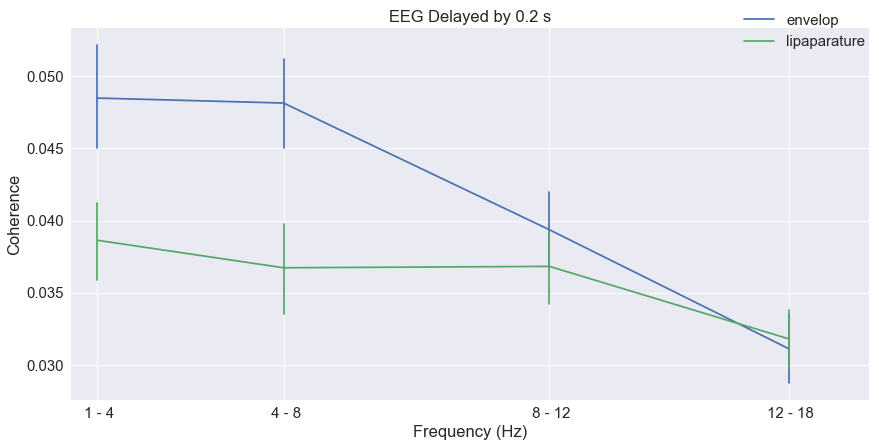

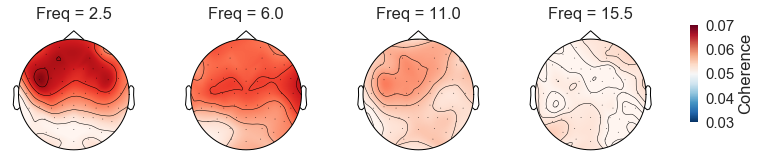

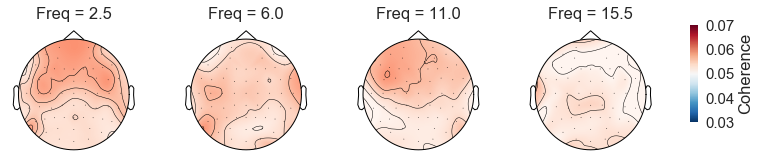

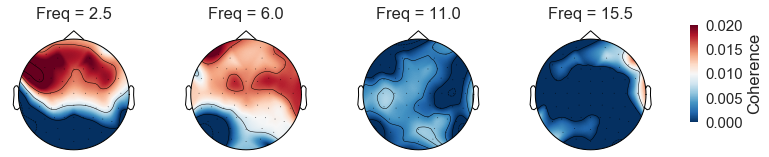

In [11]:
# plot coherence onf features in single delay for features

fi = [2.5,6,11,15.5,23,33.5]
fi = [2.5,6,11,15.5]

freq = [ ' 1 - 4Hz',
 ' 4 - 8Hz',
 ' 8 - 12Hz',
 ' 12 - 18Hz',
 ' 18 - 27Hz',
 ' 27 - 40Hz']
freq = [ ' 1 - 4',
 ' 4 - 8',
 ' 8 - 12',
 ' 12 - 18']
features = ['envelop','lipaparature']
#features = ['envelop']


delay = [0.2]
plot_freq_avg(data,delay,features,fi,freq,condition,subject_name)

df1,A1 = get_subject_avg_inFreq(data,delay,features[0],fi,condition,subject_name)
vmin = np.round(min(A1),decimals=2)
vmax = np.round(max(A1),decimals=2)
plot_topo_image(df1,vmin,vmax,'Freq')


df2,A2 = get_subject_avg_inFreq(data,delay,features[1],fi,condition,subject_name)
vmin = np.round(min(A1),decimals=2)
vmax = np.round(max(A1),decimals=2)
plot_topo_image(df2,vmin,vmax,'Freq')


df = df1
df['Data'] = df1['Data']-df2['Data']
A = np.asarray(A1) - np.asarray(A2)
vmin = np.round(min(A),decimals=2)
vmax = np.round(max(A),decimals=2)
plot_topo_image(df,vmin,vmax,'Freq')

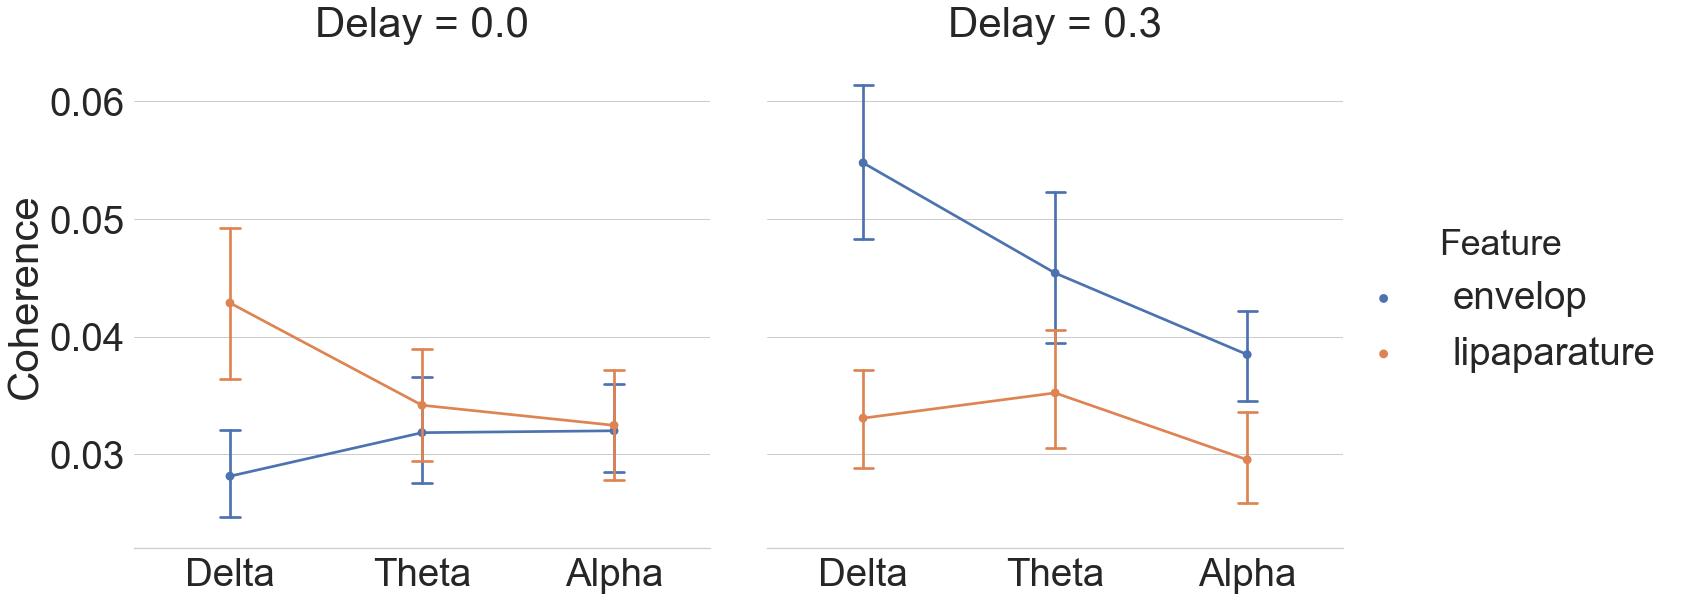

In [188]:
#
features = ['envelop','lipaparature']



fi = [2.5]
delay = [0,0.3]
freq = [ ' 1 - 4Hz']
freq = [ 'Delta']

fi = [2.5,6,10]
delay = [0,0.3]
freq = [ ' 1 - 4Hz',
 ' 4 - 8Hz',
 ' 8 - 12Hz']
freq = [ 'Delta',
 'Theta',
 'Alpha']

a = data.loc[features,fi,condition,delay,subject_name]['Coherence']
a = pd.DataFrame(a.reset_index())

#f, AX = plt.subplots(figsize=(15,6))

#ax = sns.barplot(x="Freq", y="Coherence", hue="Feature", data=a,capsize=.2)
#ax.set_xticklabels(freq,rotation=0)
#ax.set_title('Delay '+ str(int(delay[0]*1000)) +' ms')
sns.set(font_scale=3.5)
sns.set_style("whitegrid")

g = sns.catplot(x="Freq", y="Coherence", hue="Feature", data=a, col="Delay", kind="point", 
                height=10, aspect=1,
                capsize=.1)
g.set_xticklabels(freq,rotation=0)
(g.despine(left=True))  
#g.set_titles('')
g.set_xlabels('')
g.set(ylim=(0.022, 0.065))
#g.set_xticklabels('')
#plt.legend(loc=1, prop={'size': 15})
g.savefig('temp.png', transparent=True)


AttributeError: 'AxesSubplot' object has no attribute 'despine'

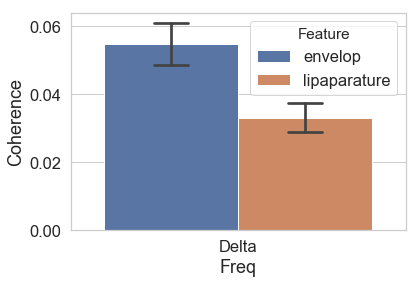

In [115]:
#
fi = [2.5,6,10]
delay = [0.3]
freq = [ ' 1 - 4Hz',
 ' 4 - 8Hz',
 ' 8 - 12Hz']
freq = [ 'Delta',
 'Theta',
 'Alpha']
sns.set_style("whitegrid")

a = data.loc[features,fi,condition,delay,subject_name]['Coherence']
a = pd.DataFrame(a.reset_index())
ax = sns.barplot(x="Freq", y="Coherence", hue="Feature",data=a, capsize=.1)
ax.set_xticklabels(freq,rotation=0)
plt.legend(loc=1, prop={'size': 12})
ax.despine(left=True)


C:\Users\EspVicon\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


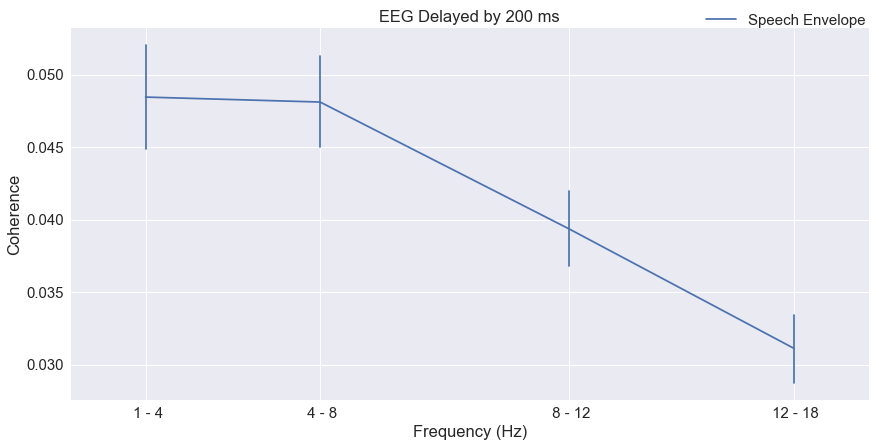

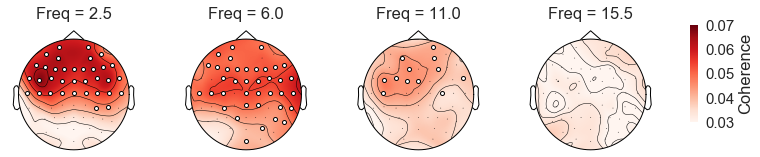

In [40]:
# plot coherence onf features in single delay for features (with stats)


fi = [2.5,6,11,15.5,23,33.5]
fi = [2.5,6,11,15.5]

freq = [ ' 1 - 4Hz',
 ' 4 - 8Hz',
 ' 8 - 12Hz',
 ' 12 - 18Hz',
 ' 18 - 27Hz',
 ' 27 - 40Hz']
freq = [ ' 1 - 4',
 ' 4 - 8',
 ' 8 - 12',
 ' 12 - 18']
features = ['envelop']


delay = [0.2]
a = data.loc[features,fi,condition,delay,subject_name]['Coherence']
a = pd.DataFrame(a.reset_index())

g = sns.FacetGrid(a,  col='Delay',size=6,aspect=2)
b = g.map_dataframe(sns.tsplot, time="Freq", unit="Subject",condition="Feature", value="Coherence",
                color="deep", err_style="ci_bars")
b = b.set_xlabels('Frequency (Hz)')
b = b.set_ylabels('Coherence')
b.set(xticks=fi,xlim=(1, 17))
b.set_xticklabels(freq,rotation=0)

b.fig.legend(['Speech Envelope'],loc=1)
b.set_titles('EEG Delayed by 200 ms')

# paired permtutation t-test with surrogate frequency band

a = data_surrogate.loc[features,fi,condition,delay,subject_name]['random_data']
a = a.reset_index()
df = pd.DataFrame(np.column_stack(list(zip(*a.random_data))), columns=info.ch_names)
dataS = pd.concat([a,df], axis=1)
dataS.set_index(['Feature','Freq','Condition','Delay','Subject'], inplace=True)
dataS.sort_index(inplace=True)

# permutation stat
numSamples = 1000
P = get_P_value_coherence_parallel_ch_surrogate(data,dataS,features,fi,condition,
                                                delay,subject_name,numSamples,info.ch_names)
a = fdr_correction(P['p-value'].get_values(), alpha=0.05, method='indep')
P['FDRp-value'] = a[1]

######################################################################
ch = P[P['FDRp-value'] <= 0.05]['channel'].get_values()
dd = P[P['FDRp-value'] <= 0.05]['Freq'].get_values()

frame = []
for d in fi:
    indices = [i for i, x in enumerate(dd) if x == d]
    mask = ch[indices]
    mask = np.in1d(info.ch_names,mask)    
    a = []
    for s in subject_name:
        A = data.loc[features,d,condition,delay,s]['Data'].get_values()
        a.append(A[0])    
    A = np.asarray(a)
    A = A.mean(axis=0)
    df = pd.DataFrame({'Data':[A],'Freq':d,'mask':[mask]})
    frame.append(df)
    
df=pd.concat((frame),axis=0)

A = np.vstack(df['Data'].get_values())
vmin = np.round(A.min(),decimals=2)
vmax = np.round(A.max(),decimals=2)
plot_topo_image(df,vmin,vmax,'Freq','Reds') 

In [7]:
# comparison multitaper , furrier
save_path = data_path + '/data/coherence/coh-fourier-1-40.5Hz-0.5step_additinalSegments.pkl'
dataF=pd.read_pickle(save_path)
a  = dataF['Data'].apply(lambda x: np.mean(x))
dataF['Coherence'] = pd.Series(a, index=dataF.index)


save_path = data_path + '/data/coherence/coh-multitaper3cycle-1-40.5Hz-0.5step_envelop_increase_additinalSegments.pkl'
dataM=pd.read_pickle(save_path)
a  = dataM['Data'].apply(lambda x: np.mean(x))
dataM['Coherence'] = pd.Series(a, index=dataM.index)




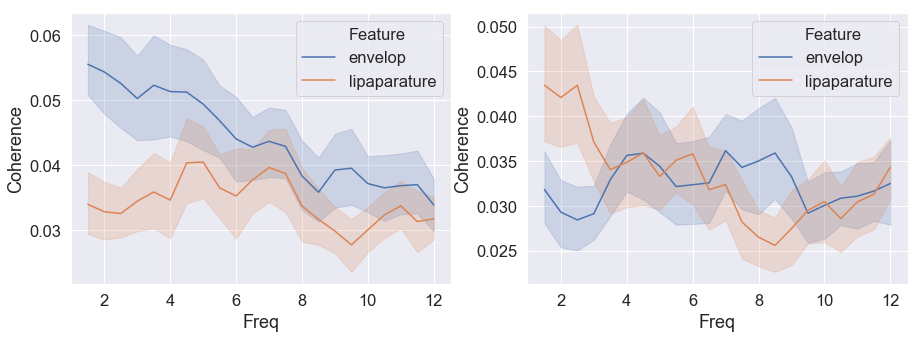

In [10]:
#
freq = np.arange(1,12.5,0.5)
features = ['envelop','lipaparature']

F = dataM[(dataM['Condition']=='All') & (dataM['Delay']==0.3) & (dataM['Feature'].isin(features)) & (dataM['Freq'].isin(freq))]
M = dataM[(dataM['Condition']=='All') & (dataM['Delay']==0) & (dataM['Feature'].isin(features)) & (dataM['Freq'].isin(freq))]

f, ax = plt.subplots(figsize=(15,5))
plt.subplot(1, 2, 1)
sns.lineplot(data=F,x='Freq',y='Coherence',hue='Feature')
plt.subplot(1, 2, 2)
sns.lineplot(data=M,x='Freq',y='Coherence',hue='Feature')

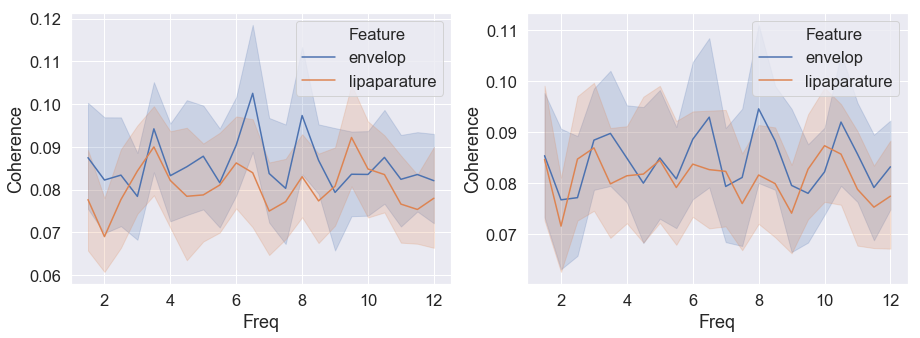

In [11]:
#
freq = np.arange(1,12.5,0.5)
features = ['envelop','lipaparature']

F = dataF[(dataF['Condition']=='All') & (dataF['Delay']==0.3) & (dataF['Feature'].isin(features)) & (dataF['Freq'].isin(freq))]
M = dataF[(dataF['Condition']=='All') & (dataF['Delay']==0) & (dataF['Feature'].isin(features)) & (dataF['Freq'].isin(freq))]

f, ax = plt.subplots(figsize=(15,5))
plt.subplot(1, 2, 1)
sns.lineplot(data=F,x='Freq',y='Coherence',hue='Feature')
plt.subplot(1, 2, 2)
sns.lineplot(data=M,x='Freq',y='Coherence',hue='Feature')

In [113]:
sns.set(font_scale=1)
freq = np.arange(0.5,15.5)
delay = np.arange(-5,5.5,0.5) / 10
condition = ['All']

Text(0.5,1,'envelop - lip')

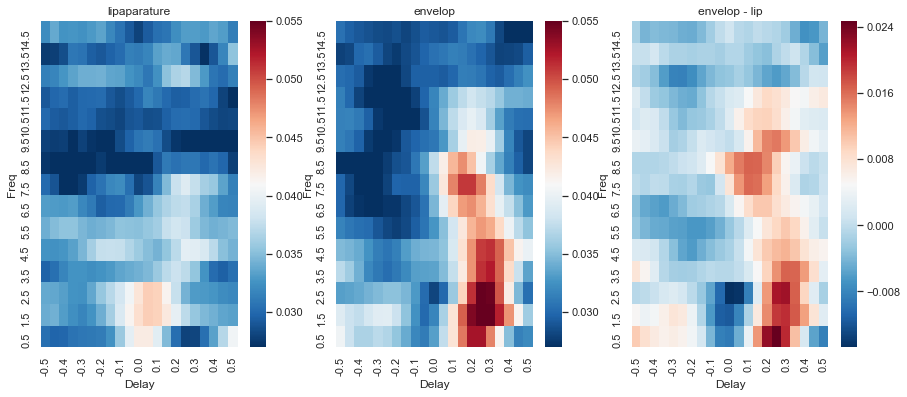

In [114]:
# freq delay heatmap for all feaarues
features = ['lipaparature']
A = data.loc[features,freq,condition,delay,subject_name]['Coherence']
A = A.reset_index()
a = A.groupby(['Feature','Freq','Delay'])['Coherence'].mean().reset_index()

features = ['envelop']
B = data.loc[features,freq,condition,delay,subject_name]['Coherence']
B = B.reset_index()
b = B.groupby(['Feature','Freq','Delay'])['Coherence'].mean().reset_index()

x=a.copy()
x['Coherence'] = b['Coherence'].get_values() - a['Coherence'].get_values()

a = pd.DataFrame(a)
a = a.pivot(index="Freq", columns="Delay", values="Coherence")
b = pd.DataFrame(b)
b = b.pivot(index="Freq", columns="Delay", values="Coherence")
x = pd.DataFrame(x)
x = x.pivot(index="Freq", columns="Delay", values="Coherence")

cmap='RdBu_r'
f, AX = plt.subplots(figsize=(15,6))
plt.subplot(1,3,1)
ax = sns.heatmap(a, vmin = 0.027, vmax=0.055,cmap = cmap)
ax.invert_yaxis()
plt.title('lipaparature')
plt.subplot(1,3,2)
ax = sns.heatmap(b,  vmin = 0.027, vmax=0.055, cmap = cmap)
ax.invert_yaxis()
plt.title('envelop')
plt.subplot(1,3,3)
ax = sns.heatmap(x, cmap = cmap)
ax.invert_yaxis()
plt.title('envelop - lip')




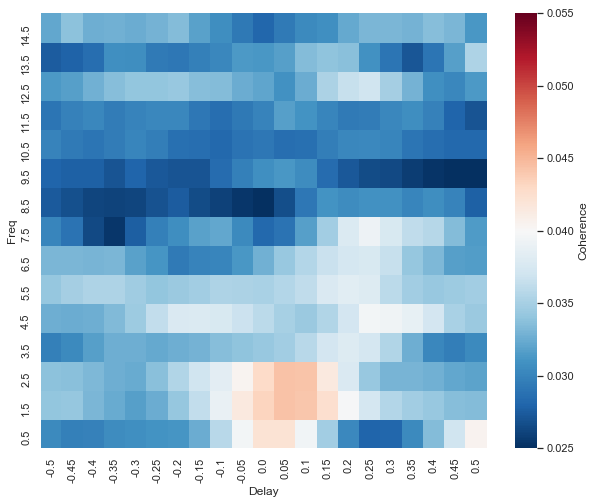

In [115]:
xx=a
fig = plt.figure(figsize=(10,8))

aa=sns.heatmap(xx, vmin = 0.025, vmax=0.055,cmap = cmap,cbar_kws={'label': 'Coherence'})
aa.invert_yaxis()

(0.5, 14.5)

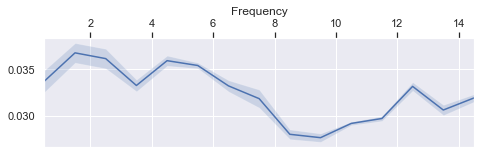

In [116]:
#
y=xx.get_values().mean(axis=1)
y_std=xx.get_values().std(axis=1) / np.sqrt(len(y))

f, ax = plt.subplots(figsize=(7.7,2))

ax.plot(freq,y)
ax.fill_between(freq, y - y_std, y + y_std,alpha=0.2)

#ax.invert_xaxis()
plt.xlabel('Frequency')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
plt.xlim([freq[0],freq[-1]])

(-0.5, 0.5)

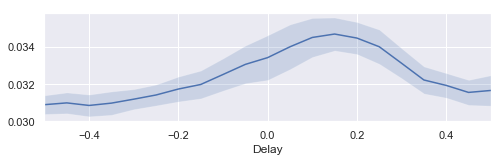

In [117]:
#
x=xx.get_values().mean(axis=0)
x_std=xx.get_values().std(axis=0) / np.sqrt(len(x))

f, ax = plt.subplots(figsize=(8,2))

ax.plot(delay,x)
ax.fill_between(delay, x - x_std, x + x_std,alpha=0.2)
plt.xlabel('Delay')
plt.xlim([-0.5,0.5])

Text(318.348,0.5,'Coherence')

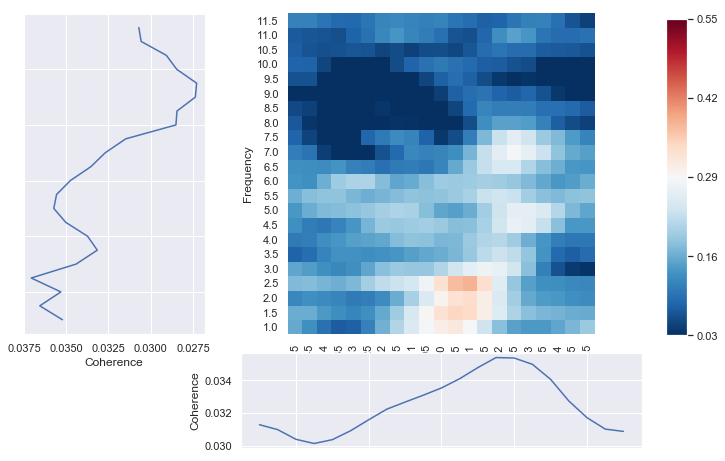

In [25]:
#
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.colorbar import colorbar

x=a.get_values().mean(axis=0)
y=a.get_values().mean(axis=1)

vmin = 0.027
vmax= 0.55

fig = plt.figure(figsize=(15,8))

gs = GridSpec(4,4)
#gs.update(wspace=0.4)

ax_joint = fig.add_subplot(gs[0:3,1:3])
ax_marg_y = fig.add_subplot(gs[0:3,0])
ax_marg_x = fig.add_subplot(gs[3,1:3])

sns.heatmap(a, vmin = 0.027, vmax=0.055,cmap = cmap,ax=ax_joint,cbar=False)
ax_joint.invert_yaxis()

ax_marg_x.plot(delay,x)
ax_marg_y.plot(y,freq)
ax_marg_y.invert_xaxis()

im = ax_joint.imshow(np.array([[0,1]]), cmap="RdBu_r")
im.set_visible(False)
cbaxes = fig.add_axes([0.72, 0.32, 0.02, 0.55])  # This is the position for the colorbar

aa=colorbar(im, cax=cbaxes,ticks=np.round(np.linspace(0,1,5),decimals=2))
aa.ax.set_yticklabels(np.round(np.linspace(vmin,vmax,5),decimals=2))  # vertically oriented colorbar

# Turn off tick labels on marginals
aa=plt.setp(ax_marg_x.get_xticklabels(), visible=False)
aa=plt.setp(ax_marg_y.get_yticklabels(), visible=False)

# Set labels on joint
ax_joint.set_xlabel('Delay')
ax_joint.set_ylabel('Frequency')
# Set labels on marginals
ax_marg_y.set_xlabel('Coherence')
ax_marg_x.set_ylabel('Coherence')
#gs.tight_layout(fig,rect=[0.5, 0, 1, 1], h_pad=0.5)


In [120]:
freq = np.arange(0.5,15.5,0.5)
features = ['envelop','lipaparature']

Text(0.5,1,'0.25ms Delay')

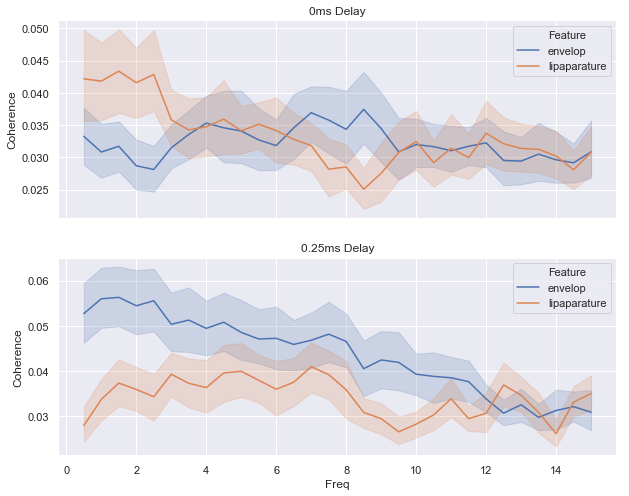

In [121]:
# freq delay heatmap for all feaarues

d1 = [0]
A = data.loc[features,freq,condition,d1,subject_name]['Coherence']
A = A.reset_index()


d2 = [0.25]
B = data.loc[features,freq,condition,d2,subject_name]['Coherence']
B=B.reset_index()


f, AX = plt.subplots(figsize=(10,8))

plt.subplot(2,1,1)
ax=sns.lineplot(data=A,x='Freq',y='Coherence',hue='Feature')
aa=plt.setp(ax.get_xticklabels(), visible=False)
plt.xlabel('')
plt.title(str(d1[0])+'ms Delay')

plt.subplot(2,1,2)
sns.lineplot(data=B,x='Freq',y='Coherence',hue='Feature')
plt.title(str(d2[0])+'ms Delay')

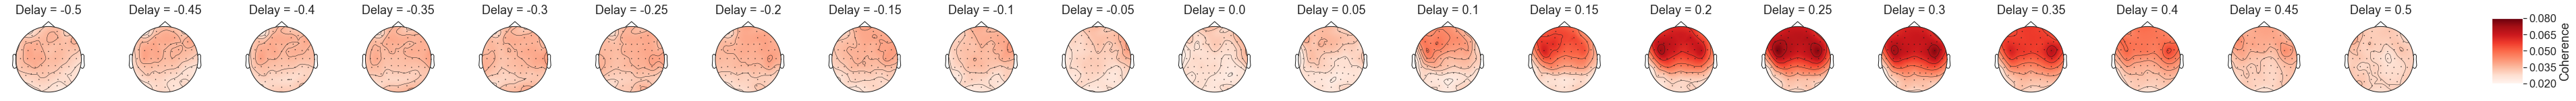

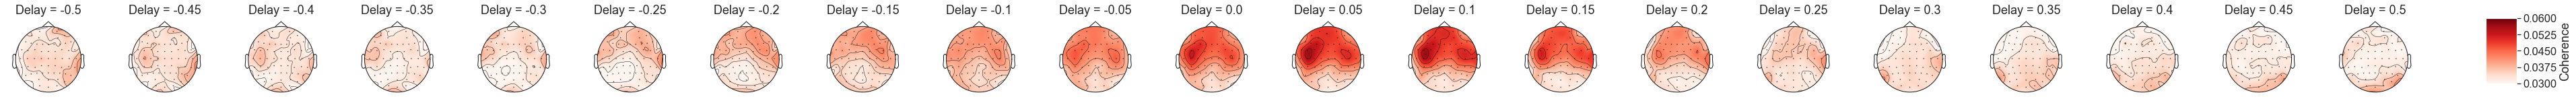

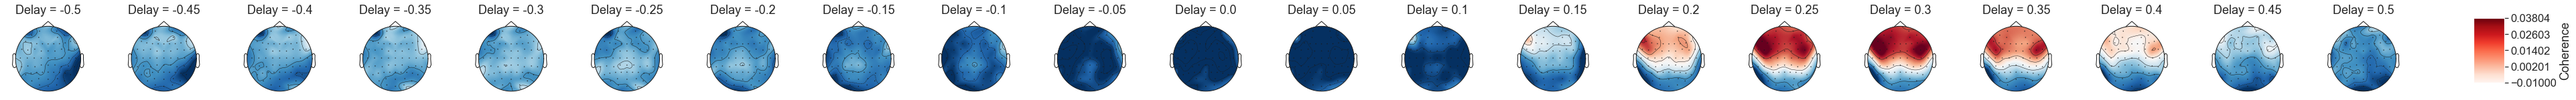

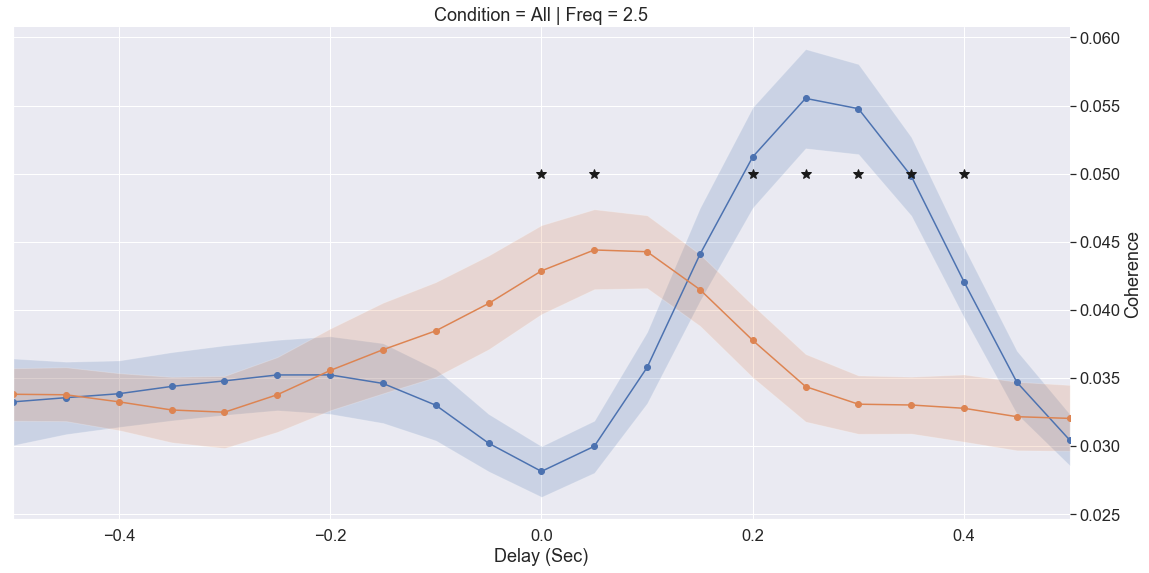

In [200]:
# see topo and avg coherence of features in delays

features = ['envelop','lipaparature']

delay = np.arange(-5,5.5,0.5) / 10
freq = [2.5]

df1,A1 = get_subject_avg_inDelay(data,delay,features[0],freq,condition,subject_name)
vmin = np.round(min(A1),decimals=2)
vmax = np.round(max(A1),decimals=2)
plot_topo_image(df1,vmin,vmax,'Delay','Reds')

df2,A2 = get_subject_avg_inDelay(data,delay,features[1],freq,condition,subject_name)
vmin = np.round(min(A2),decimals=2)
vmax = np.round(max(A2),decimals=2)
plot_topo_image(df2,vmin,vmax,'Delay','Reds')

df = df1
df['Data'] = df1['Data']-df2['Data']
A = np.asarray(A1) - np.asarray(A2)
vmin = np.round(min(A),decimals=5)
vmax = np.round(max(A),decimals=5)
vmin=-0.01
vamx=0.01
plot_topo_image(df,vmin,vmax,'Delay','Reds')

# stat
P = get_P_value_Coherence(data,features,freq,condition,delay,subject_name)
a = fdr_correction(P['p-value'].get_values(), alpha=0.05, method='indep')
P['FDRp-value'] = a[1]
x = P[P['FDRp-value'] <= 0.05]['Delay'].get_values()
y = np.repeat(0.05,len(x))

plot_delay_avg(data,delay,features,freq,condition,subject_name)
x = plt.plot(x,y, marker='*', color='k',markersize=10,linestyle='')


# best channel
ch1 = info.ch_names[np.argmax(df1['Data'].mean())]
#plot_delay_avg_BestChannel(data,delay,features,freq,condition,subject_name,ch1)
ch1 = info.ch_names[np.argmax(df2['Data'].mean())]
#plot_delay_avg_BestChannel(data,delay,features,freq,condition,subject_name,ch1)

C:\Users\EspVicon\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


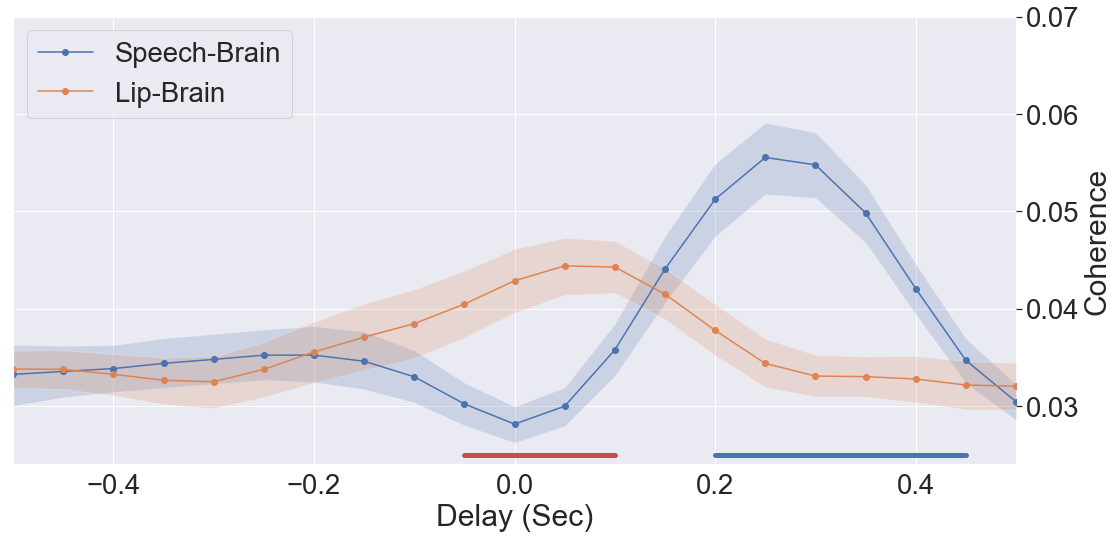

In [63]:
# paper figure3
def plot_delay_avg(data,delay,features,freq,condition,subject_name):
    a = data.loc[features,freq,condition,delay,subject_name]['Coherence']
    a = a.reset_index()

    g = sns.FacetGrid(a, col="Freq", row="Condition",margin_titles=False,height=8,aspect=2)
    b = g.map_dataframe(sns.tsplot, time="Delay", unit="Subject",condition="Feature",value="Coherence",color="deep",marker='o')
    #b = g.map_dataframe(sns.lineplot, x="Delay",hue="Feature", y="Coherence",color="deep",marker='o')
    b = b.set_xlabels('Delay (Sec)')
    
    b.ax.yaxis.tick_right()
    b.ax.yaxis.set_label_position("right")
    b.set_ylabels('Coherence')
    
sns.set(font_scale=2.5)
sns.set_style("darkgrid")


delay = np.arange(-5,5.5,0.5) / 10
freq = [2.5]
features = ['envelop','lipaparature']

#f, AX = plt.subplots(figsize=(15,8))


plot_delay_avg(data,delay,features,freq,condition,subject_name)
#plt.legend(['Speech-Brain','Lip-Brain'],loc=2)
#plt.title('Freq = 1 - 4 Hz')
plt.ylim([0.024, 0.07])
plt.title('')
plt.xlabel('Delay (Sec)')

plt.axhline(y=0.025, xmin=0.45, xmax=0.6, linewidth=5, color = 'r')
plt.axhline(y=0.025, xmin=0.7, xmax=0.95, linewidth=5, color = 'b')
#plt.legend(['Speech-Brain','Lip-Brain','Lip > Speech','Speech > Lip'],loc=2)
plt.legend(['Speech-Brain','Lip-Brain'],loc=2)


In [194]:
freq = [2.5]
features = ['lipaparature']
features = ['envelop']

delay = np.arange(-5,5.5,0.5) / 10
condition = ['All']
A=[]
for d in delay:
    a = data.loc[features,freq,condition,d,subject_name]['Data'].get_values()
    a = np.stack(a)
    a = a.mean(axis=1)
    A.append(a.mean(axis=0))
    
A=np.asarray(A)
A.mean()

0.03783040808559698

In [186]:
freq = [2.5,6,11]
features = ['envelop']
delay = np.arange(-5,5.5,0.5) / 10
condition = ['All']
F=[]
for f in freq:
    A=[]
    for d in delay:
        a = data.loc[features,f,condition,d,subject_name]['Data'].get_values()
        a = np.stack(a)
        a = a.mean(axis=1)
        A.append(a.mean(axis=0))    
    A=np.asarray(A)
    F.append(A)
    
F=np.asarray(F)

from scipy import stats
 
a, p = stats.f_oneway(F[0,:], F[1,:], F[2,:])

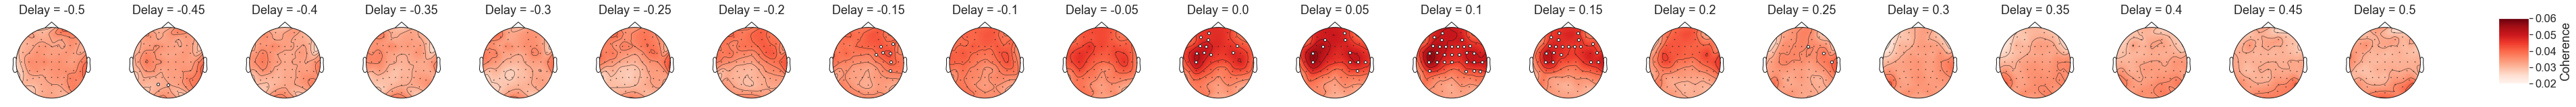

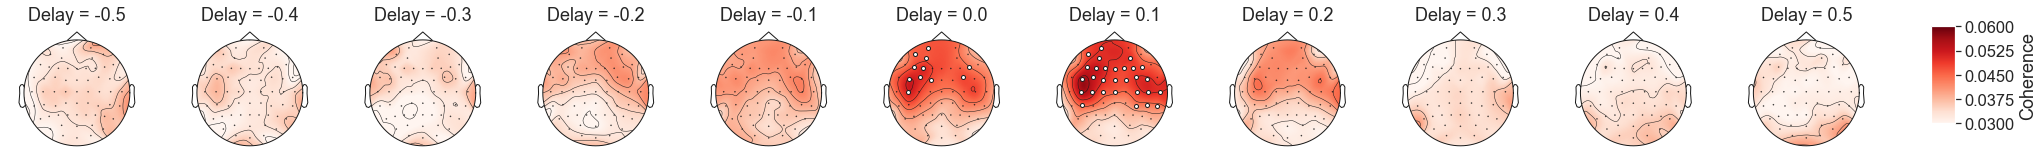

In [24]:
# paired permutaion t-test (surrogate)

freq_band = [2.5]
features = ['envelop']
features = ['lipaparature']
delay = np.arange(-5,5.5,0.5) / 10
#delay = np.arange(-5,6) / 10


a = data.loc[features,freq_band,condition,delay,subject_name]['Data']
a = a.reset_index()
df = pd.DataFrame(np.column_stack(list(zip(*a.Data))), columns=info.ch_names)
dataO = pd.concat([a,df], axis=1)
dataO.set_index(['Feature','Freq','Condition','Delay','Subject'], inplace=True)
dataO.sort_index(inplace=True)

a = data_surrogate.loc[features,freq_band,condition,delay,subject_name]['random_data']
a = a.reset_index()
df = pd.DataFrame(np.column_stack(list(zip(*a.random_data))), columns=info.ch_names)
dataS = pd.concat([a,df], axis=1)
dataS.set_index(['Feature','Freq','Condition','Delay','Subject'], inplace=True)
dataS.sort_index(inplace=True)

# permutation stat
numSamples = 1000
P = get_P_value_coherence_parallel_ch_surrogate(dataO,dataS,features,freq_band,condition,
                                                delay,subject_name,numSamples,info.ch_names)
a = fdr_correction(P['p-value'].get_values(), alpha=0.05, method='indep')
P['FDRp-value'] = a[1]

######################################################################
ch = P[P['FDRp-value'] <= 0.05]['channel'].get_values()
dd = P[P['FDRp-value'] <= 0.05]['Delay'].get_values()
frame = []
for d in delay:
    indices = [i for i, x in enumerate(dd) if x == d]
    mask = ch[indices]
    mask = np.in1d(info.ch_names,mask)    
    a = []
    for s in subject_name:
        A = data.loc[features,freq_band,condition,d,s]['Data'].get_values()
        a.append(A[0])    
    A = np.asarray(a)
    A = A.mean(axis=0)
    df = pd.DataFrame({'Data':[A],'Delay':d,'mask':[mask]})
    frame.append(df)
    
df=pd.concat((frame),axis=0)
    
A = np.vstack(df['Data'].get_values())
vmin = np.round(A.min(),decimals=2)
vmax = np.round(A.max(),decimals=2)
vmin = 0.02
vmax = 0.06
plot_topo_image(df,vmin,vmax,'Delay','Reds') 


delay = np.arange(-5,6) / 10
aa = df.loc[df['Delay'].isin(delay)]
A = np.vstack(aa['Data'].get_values())
vmin = np.round(A.min(),decimals=2)
vmax = np.round(A.max(),decimals=2)  
#vmin = 0.02
#vmax = 0.06
plot_topo_image(aa,vmin,vmax,'Delay','Reds')  

In [124]:

save_path = data_path + '/data/paper/surrogate_data.pkl'
data_surrogate.to_pickle(save_path)

In [3]:
# read surrogate coherence

save_path = data_path + '/data/paper/surrogate_data.pkl'
data_surrogate = np.load(save_path)

In [255]:
data_surrogate.set_index(['Feature','Freq','Condition','Delay','Subject'], inplace=True)
data_surrogate.sort_index(inplace=True)

KeyError: 'Feature'

In [253]:
freq_band = np.arange(1.5,13,0.5)
features = ['envelop']
features = ['lipaparature']

condition = ['All']
delay = np.arange(-5,5.5,0.5) / 10

In [254]:
# cluster permutaion get data (surrogate)
def get_data_for_clusterpermutation(data1,data2,f1,f2,freq_band,condition,delay,subject_name):
    frame1 =[]
    frame2 =[]
    for d in delay:
        A = data1.loc[f1,freq_band,condition,d,subject_name]['Data'].get_values()
        B = data2.loc[f2,freq_band,condition,d,subject_name]['random_data'].get_values()
        condition2 = np.stack(B)
        condition1 = np.stack(A)

        frame1.append(condition1)
        frame2.append(condition2)


    condition1 = np.swapaxes(frame1,0,1)
    condition2 = np.swapaxes(frame2,0,1)
    
    return condition1,condition2

def get_data_for_clusterpermutation2(data1,data2,f1,f2,freq_band,condition,delay,subject_name):
    frame1 =[]
    frame2 =[]
    for d in delay:
        C = []
        D = []
        for fr in freq_band:
            A = data1.loc[f1,fr,condition,d,subject_name]['Data'].get_values()
            B = data2.loc[f2,fr,condition,d,subject_name]['random_data'].get_values()
            condition2 = np.stack(B)
            condition1 = np.stack(A)

            C.append(condition1)
            D.append(condition2)
        frame1.append(np.stack(C))
        frame2.append(np.stack(D))

    frame1 = np.stack(frame1)
    frame2 = np.stack(frame2)

    condition1 = np.swapaxes(frame1,0,2)
    condition2 = np.swapaxes(frame2,0,2)
    
    return condition1,condition2




condition1,condition2=get_data_for_clusterpermutation2(data,data_surrogate,features,features,
                                                      freq_band,condition,delay,subject_name)

A = []
for s in range(0,len(subject_name)):
    A.append(condition1[s,:,:,:] - condition2[s,:,:,:])
    

condition1 = np.swapaxes(condition1,1,3)
condition2 = np.swapaxes(condition2,1,3)
condition1 = np.swapaxes(condition1,2,3)
condition2 = np.swapaxes(condition2,2,3)


KeyError: 'the label [1.5] is not in the [columns]'

In [ ]:
freq_band = np.arange(1.5,13,0.5)
delay = np.arange(-5,5.5,0.5) / 10
features = ['envelop', 'lipaparature']


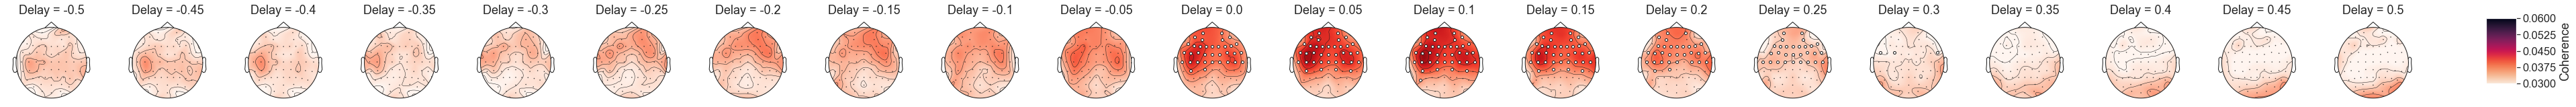

In [45]:
# cluster permutaitation (surrogate)
def compute_cluster_permutation_coherence_surrogate(condition1,condition2):
    fname = os.path.dirname(os.path.dirname(os.getcwd())) + '/fieldtrip_eeg_clean\mat/acticap-64ch-standard2_ferrara_neighb_for_mne.mat'
    connectivity ,ch_names = mne.channels.read_ch_connectivity(fname)
    #connectivity ,ch_names = mne.channels.find_ch_connectivity(info.info,'eeg')

    stat_fun_hat = partial(ttest_1samp_no_p, sigma=1e-3)       
    threshold_tfce = dict(start=0, step=0.2)

    X = [condition1,condition2]
    #X = condition1-condition2
    
    p_threshold = 0.05
    threshold_tfce = -stats.distributions.t.ppf(p_threshold / 2., condition1.shape[0] - 1)
    #print(threshold_tfce)
    T, clusters, cluster_p_values, H0 = mne.stats.spatio_temporal_cluster_test(X,n_permutations=1000, 
                                                                 #connectivity = connectivity,
                                                                           #stat_fun=stat_fun_hat,
                                                                           #check_disjoint =True,
                                                                       threshold=threshold_tfce, 
                                                                                     #step_down_p =0.05,
                                                                                     #max_step = 2,
                                                                               tail=0,
                                                                               n_jobs =7,
                                                                          verbose='WARNING')

    T_obs_plot = np.nan * np.ones_like(T)
    for c, p_val in zip(clusters, cluster_p_values):
        if p_val <= 0.025:
            T_obs_plot[c] = T[c]

    mask = np.invert(np.isnan(T_obs_plot))
    return T, mask,cluster_p_values,T_obs_plot


# cluster permutaion get data (surrogate)
def get_data_for_clusterpermutation(data1,data2,f1,f2,freq_band,condition,delay,subject_name):
    frame1 =[]
    frame2 =[]
    for d in delay:
        A = data1.loc[f1,freq_band,condition,d,subject_name]['Data'].get_values()
        B = data2.loc[f2,freq_band,condition,d,subject_name]['random_data'].get_values()
        condition2 = np.stack(B)
        condition1 = np.stack(A)

        frame1.append(condition1)
        frame2.append(condition2)


    condition1 = np.swapaxes(frame1,0,1)
    condition2 = np.swapaxes(frame2,0,1)
    
    return condition1,condition2



freq_band = [2.5]

features = ['envelop']
features = ['lipaparature']

delay = np.arange(-5,5.5,0.5) / 10

condition1,condition2=get_data_for_clusterpermutation(data,data_surrogate,features[0],features[0],
                                                      freq_band,condition,delay,subject_name)


T, mask,cluster_p_values,T_obs_plot = compute_cluster_permutation_coherence_surrogate(condition1,condition2)
A=np.mean(condition1,axis=0)
frame = []
for d in range(0,len(delay)):
    df = pd.DataFrame({'mask':[mask[d,:]],'Data':[A[d,:]],'Delay':delay[d]})
    frame.append(df)
df = pd.concat((frame),axis=0)

vmin = np.round(min(A.flatten()),decimals=2)
vmax = np.round(max(A.flatten()),decimals=2)

plot_topo_image2(df,vmin,vmax,'Delay')



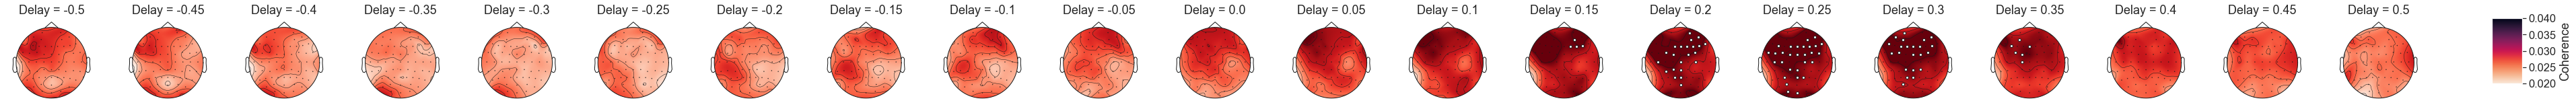

In [12]:
# get mask from filedtrip
freq_band = [10]

features = ['lipaparature']
features = ['envelop']

delay = np.arange(-5,5.5,0.5) / 10



# cluster permutaion get data (surrogate)
def get_data_for_clusterpermutation(data1,data2,f1,f2,freq_band,condition,delay,subject_name):
    frame1 =[]
    frame2 =[]
    for d in delay:
        A = data1.loc[f1,freq_band,condition,d,subject_name]['Data'].get_values()
        B = data2.loc[f2,freq_band,condition,d,subject_name]['random_data'].get_values()
        condition2 = np.stack(B)
        condition1 = np.stack(A)

        frame1.append(condition1)
        frame2.append(condition2)


    condition1 = np.swapaxes(frame1,0,1)
    condition2 = np.swapaxes(frame2,0,1)
    
    return condition1,condition2

condition1,condition2=get_data_for_clusterpermutation(data,data_surrogate,features[0],features[0],
                                                      freq_band,condition,delay,subject_name)

A=np.mean(condition1,axis=0)


#
raw_fname = data_path + '/entrainment_python/2.5lip_mask.mat'
raw_fname = data_path + '/entrainment_python/2.5envelop_mask.mat'
raw_fname = data_path + '/entrainment_python/6envelop_mask.mat'
raw_fname = data_path + '/entrainment_python/10envelop_mask.mat'

mat = scipy.io.loadmat(raw_fname)

mask = mat['mask']
mask = np.array(mask, dtype=bool)


frame = []
for d in range(0,len(delay)):
    df = pd.DataFrame({'mask':[mask[:,d]],'Data':[A[d,:]],'Delay':delay[d]})
    frame.append(df)
df = pd.concat((frame),axis=0)

vmin = np.round(min(A.flatten()),decimals=2)
vmax = np.round(max(A.flatten()),decimals=2)

plot_topo_image2(df,vmin,vmax,'Delay')


In [35]:
# save data

save_path = data_path + '/data/paper/'+features[0]+'-surrogate_'+ str(freq_band[0])+'HzClusterPermutation.pkl'
df.to_pickle(save_path)

In [17]:
# loda data
save_path = data_path + '/data/paper/'+features[0]+'-surrogate_'+ str(freq_band[0])+'HzClusterPermutation.pkl'
df = np.load(save_path)

# paper

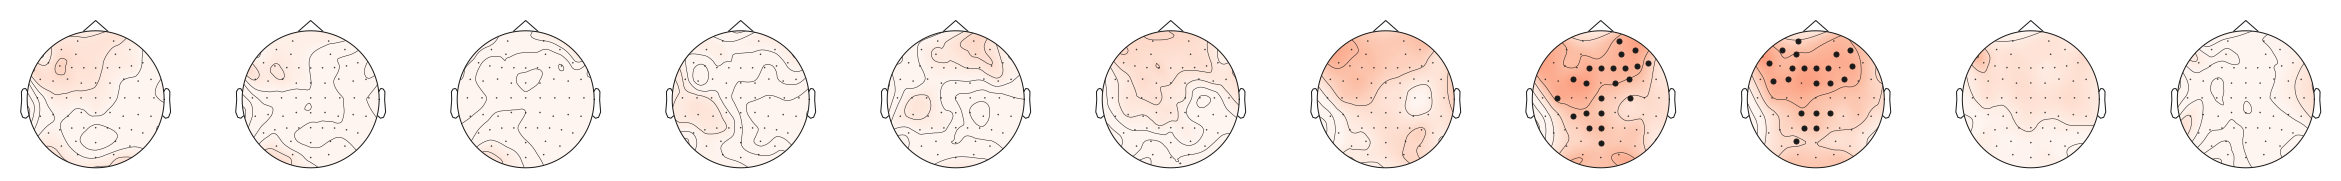

In [13]:
def plot_topo_image3(df,vmin,vmax,typeF,cmap):
    fg = sns.FacetGrid(df,col=typeF)
    b = fg.map_dataframe(draw_heatmap2, 'Data')
    b = b.set_xlabels('')
    b = b.set_titles('')
    #b.fig.subplots_adjust(top=0.7)
    #b.fig.subplots_adjust(right=0.8)
    #cbar_ax = b.fig.add_axes([0.82,0.25,0.01,0.45]) # [left, bottom, width, height] 
    #norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
    #sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    #sm.set_array([])
    #plt.colorbar(sm, ticks=np.linspace(vmin,vmax,5),cax=cbar_ax,label='Coherence')
    

def draw_heatmap2(*args, **kwargs):
    data = kwargs.pop('data')
    x = data['Data'].any() 
    if 'mask' in data:
        mask = data['mask'].any()
        mne.viz.plot_topomap(x, info.info, show=False,vmin=vmin,vmax=vmax,mask = mask,
                            mask_params = dict(marker='o', markerfacecolor='k', markeredgecolor='k',
     linewidth=0, markersize=5))
    else:
        mne.viz.plot_topomap(x, info.info, show=False,vmin=vmin,vmax=vmax)



delay = np.arange(-5,6) / 10
aa = df.loc[df['Delay'].isin(delay)]
A = np.vstack(aa['Data'].get_values())
vmin = np.round(A.min(),decimals=2)
vmax = np.round(A.max(),decimals=2)  
vmin = 0.03
vmax = 0.07
plot_topo_image3(aa,vmin,vmax,'Delay','Reds')  

In [24]:
# take min 2 neighbouring channels

#fname = os.path.dirname(os.path.dirname(os.getcwd())) + '/fieldtrip_eeg_clean\mat/acticap-64ch-standard2_ferrara_neighb_for_mne.mat'
#connectivity ,ch_names = mne.channels.read_ch_connectivity(fname)
connectivity ,ch_names = mne.channels.find_ch_connectivity(info.info,'eeg')

A = connectivity.todense() 

CC = np.full((1, 59), False)
C = CC[0]


frame = []
for d in range(0,len(delay)):
    B=[]
    a = df['mask'].get_values()[d]
    a = np.where(a)[0]
    if len(a)>2:
        for i in range(0,len(a)):
            c = np.where(A[a[i],:])[1]
            c = np.intersect1d(a,c)
            if(len(c)>2):
                B.append(a[i])
            
    #print(B) 
    if len(B)>1:
        c = np.unique(B)
        mask = np.full((1, 59), False)[0]
        mask[c] = True
    else:
        mask = np.full((1, 59), False)[0]
    aa = pd.DataFrame({'mask':[mask]})
    frame.append(aa)
    
aa=pd.concat((frame),axis=0)


df['mask2'] = aa

Could not find a connectivity matrix for the data. Computing connectivity based on Delaunay triangulations.
-- number of connected vertices : 59


[Text(0,0,'-0.035'), Text(0,0,'0'), Text(0,0,'0.035')]

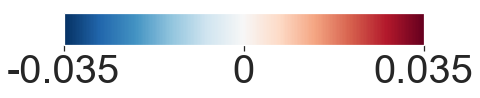

In [117]:
vmin=-0.04
vmax=-vmin


# plot colorbar
a = np.array([[0,1]])
plt.figure(figsize=(5,1.5))
img = plt.imshow(a, cmap="RdBu_r")
plt.gca().set_visible(False)
#cax = plt.axes([0.82,0.25,0.05,3])
cax = plt.axes([0.25,0.82,1,0.3])
#plt.colorbar(orientation="vertical", cax=cax)
norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
sm = plt.cm.ScalarMappable(cmap='RdBu_r', norm=norm)
sm.set_array([])
cax = plt.colorbar(sm,ticks=np.round(np.linspace(vmin,vmax,3),decimals=2),cax=cax,
             orientation="horizontal")
plt.tick_params(labelsize=40) 

vmin = -0.035
vmax=-vmin

cax.ax.set_xticklabels([vmin, '0', vmax])  # vertically oriented colorbar


# --------------------------

In [26]:
# nonpaprmetric test with debiased (surrogate)
def run_nonParametric_Ttest(x,y):
    x = x-y
    t,p = scipy.stats.mannwhitneyu(x,x*0,alternative = 'greater')
    #t,p = scipy.stats.wilcoxon(x)
    #t,p = scipy.stats.ranksums(x,x*0)
    #p=p/2
    return p


features = ['lipaparature']
#features = ['envelop']

delay = np.arange(-5,5.5,0.5) / 10
freq_band = [2.5]


a = data_surrogate.loc[features,freq_band,condition,delay,subject_name]['mean_data']
a = a.reset_index()
df = pd.DataFrame(np.column_stack(list(zip(*a.mean_data))), columns=info.ch_names)
dataS = pd.concat([a,df], axis=1)
dataS.set_index(['Feature','Freq','Condition','Delay','Subject'], inplace=True)
dataS.sort_index(inplace=True)

P = get_P_value_coherence_parallel_ch_surrogate_nonParametric(data,dataS,features,freq_band,
                                                                 condition,delay,subject_name,info.ch_names)

a = fdr_correction(P['p-value'].get_values(), alpha=0.05, method='indep')
P['FDRp-value'] = a[1]

######################################################################
ch = P[P['FDRp-value'] <= 0.05]['channel'].get_values()
dd = P[P['FDRp-value'] <= 0.05]['Delay'].get_values()
frame = []
for d in delay:
    indices = [i for i, x in enumerate(dd) if x == d]
    mask = ch[indices]
    mask = np.in1d(info.ch_names,mask)    
    a = []
    for s in subject_name:
        A = data.loc[features,freq_band,condition,d,s]['Data'].get_values()
        a.append(A[0])    
    A = np.asarray(a)
    A = A.mean(axis=0)
    df = pd.DataFrame({'Data':[A],'Delay':d,'mask':[mask]})
    frame.append(df)
    
df=pd.concat((frame),axis=0)
    
A = np.vstack(df['Data'].get_values())
vmin = np.round(A.min(),decimals=2)
vmax = np.round(A.max(),decimals=2)    

plot_topo_image(df,vmin,vmax,'Delay')  


delay = np.arange(-5,6) / 10
aa = df.loc[df['Delay'].isin(delay)]
A = np.vstack(aa['Data'].get_values())
vmin = np.round(A.min(),decimals=2)
vmax = np.round(A.max(),decimals=2)  
plot_topo_image(aa,vmin,vmax,'Delay')    

TypeError: plot_topo_image() missing 1 required positional argument: 'cmap'

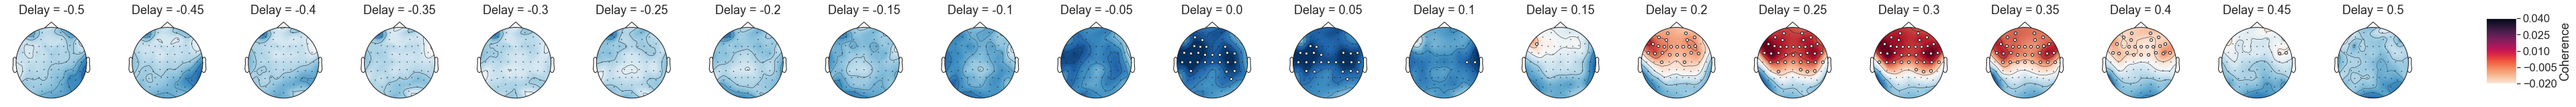

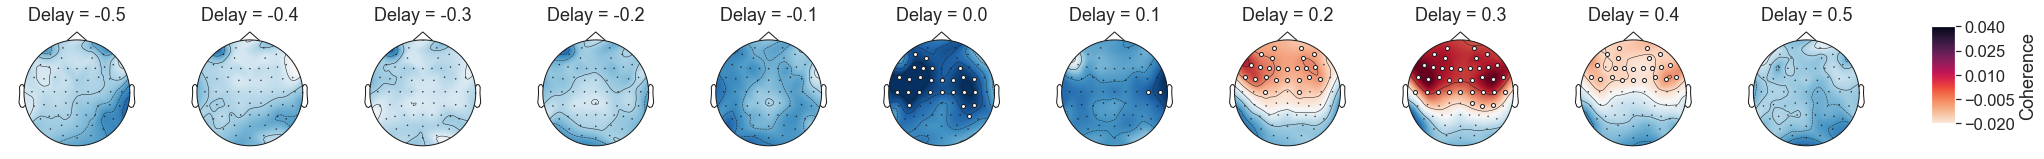

In [27]:
# paired permutaion t-test (between features)

freq_band = [2.5]
features = ['envelop','lipaparature']
condition = ['All']
delay = np.arange(-5,5.5,0.5) / 10

a = data.loc[features,freq_band,condition,delay,subject_name]['Data']
a = a.reset_index()
df = pd.DataFrame(np.column_stack(list(zip(*a.Data))), columns=info.ch_names)
dataO = pd.concat([a,df], axis=1)
dataO.set_index(['Feature','Freq','Condition','Delay','Subject'], inplace=True)
dataO.sort_index(inplace=True)

# permutation stat
numSamples = 1000
P = get_P_value_coherence_parallel_ch(dataO,features,freq_band,condition,delay,subject_name,numSamples,info.ch_names)
a = fdr_correction(P['p-value'].get_values(), alpha=0.05, method='indep')
P['FDRp-value'] = a[1]

######################################################################
ch = P[P['FDRp-value'] <= 0.05]['channel'].get_values()
dd = P[P['FDRp-value'] <= 0.05]['Delay'].get_values()
frame = []
for d in delay:
    indices = [i for i, x in enumerate(dd) if x == d]
    mask = ch[indices]
    mask = np.in1d(info.ch_names,mask)    
    a = []
    for s in subject_name:
        A = data.loc[features[0],freq_band,condition,d,s]['Data'].get_values()
        B = data.loc[features[1],freq_band,condition,d,s]['Data'].get_values()
        A = A - B
        a.append(A[0])    
    A = np.asarray(a)
    A = A.mean(axis=0)
    df = pd.DataFrame({'Data':[A],'Delay':d,'mask':[mask]})
    frame.append(df)
    
df=pd.concat((frame),axis=0)
    
A = np.vstack(df['Data'].get_values())
vmin = np.round(A.min(),decimals=2)
vmax = np.round(A.max(),decimals=2)    

plot_topo_image2(df,vmin,vmax,'Delay')    
    
    
delay = np.arange(-5,6) / 10
aa = df.loc[df['Delay'].isin(delay)]
A = np.vstack(aa['Data'].get_values())
vmin = np.round(A.min(),decimals=2)
vmax = np.round(A.max(),decimals=2) 
plot_topo_image2(aa,vmin,vmax,'Delay')    

In [10]:
save_path = data_path + '/data/paper/lip-envelop_2.5Hz_permutation_t-test_all_10000rep.pkl'
df.to_pickle(save_path)

In [48]:
# loda data
save_path = data_path + '/data/paper/lip-envelop_2.5Hz_permutation_t-test_all_10000rep.pkl'
df = np.load(save_path)

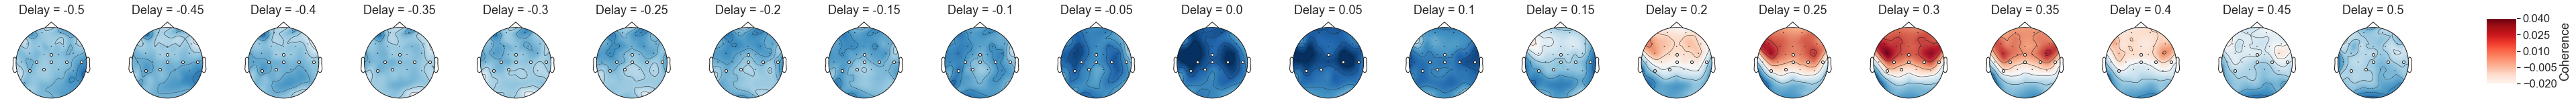

In [48]:
# cluster permutaitation  (between features)

def compute_cluster_permutation_coherence_features(condition1,condition2):
    fname = os.path.dirname(os.path.dirname(os.getcwd())) + '/fieldtrip_eeg_clean\mat/acticap-64ch-standard2_ferrara_neighb_for_mne.mat'
    connectivity ,ch_names = mne.channels.read_ch_connectivity(fname)
    #connectivity ,ch_names = mne.channels.find_ch_connectivity(info.info,'eeg')
    
    X = [condition1,condition2]
    #X = condition1-condition2
    
    stat_fun_hat = partial(ttest_1samp_no_p, sigma=1e-3)       
    threshold_tfce = dict(start=0, step=0.2)
    p_threshold = 0.05
    threshold_tfce = -stats.distributions.t.ppf(p_threshold / 2., condition1.shape[0] - 1)
    T, clusters, cluster_p_values, H0 = mne.stats.spatio_temporal_cluster_test(X,n_permutations=1000, 
                                                                 connectivity = connectivity,
                                                                           #stat_fun=stat_fun_hat,
                                                                           #check_disjoint =True,
                                                                       #threshold=threshold_tfce, 
                                                                                     #step_down_p =0.05,
                                                                                     #max_step = 2,
                                                                               tail=0,
                                                                               n_jobs =7     )

    T_obs_plot = np.nan * np.ones_like(T)
    for c, p_val in zip(clusters, cluster_p_values):
        if p_val <= 0.025:
            T_obs_plot[c] = T[c]

    mask = np.invert(np.isnan(T_obs_plot))
    return T, mask,cluster_p_values,clusters

def get_data_for_clusterpermutation(data1,data2,f1,f2,freq_band,condition,delay,subject_name):
    frame1 =[]
    frame2 =[]
    for d in delay:
        condition1 = []
        condition2 = []
        for s in subject_name:
            A = data1.loc[f1,freq_band,condition,d,s]['Data'].get_values()
            B = data2.loc[f2,freq_band,condition,d,s]['Data'].get_values()
            condition1.append(A[0])
            condition2.append(B[0])

        condition2 = np.asarray(condition2)
        condition1 = np.asarray(condition1)

        frame1.append(condition1)
        frame2.append(condition2)

    condition2 = np.asarray(frame2)
    condition1 = np.asarray(frame1)

    condition1 = np.swapaxes(condition1,0,1)
    condition2 = np.swapaxes(condition2,0,1)
    
    return condition1,condition2



freq_band = [2.5]
#freq_band = np.arange(1,4,0.5)

features = ['envelop','lipaparature']
delay = np.arange(-5,5.5,0.5) / 10

condition1,condition2=get_data_for_clusterpermutation(data,data,features[0],features[1],
                                                      freq_band,condition,delay,subject_name)

T, mask,cluster_p_values,clusters = compute_cluster_permutation_coherence_features(condition1,condition2)
A=np.mean(condition1-condition2,axis=0)
frame = []
for d in range(0,len(delay)):
    df = pd.DataFrame({'mask':[mask[d,:]],'Data':[A[d,:]],'Delay':delay[d]})
    frame.append(df)
df = pd.concat((frame),axis=0)

vmin = np.round(min(A.flatten()),decimals=2)
vmax = np.round(max(A.flatten()),decimals=2)
plot_topo_image(df,vmin,vmax,'Delay','Reds')

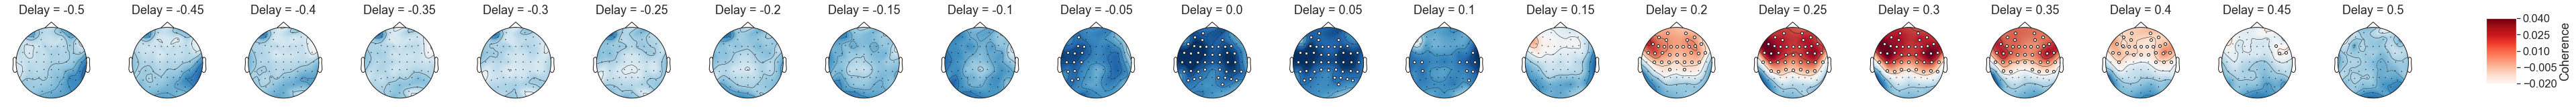

In [56]:
# get mask from filedtrip
freq_band = [2.5]
#freq_band = np.arange(1,4,0.5)

features = ['envelop','lipaparature']
delay = np.arange(-5,5.5,0.5) / 10

condition1,condition2=get_data_for_clusterpermutation(data,data,features[0],features[1],
                                                      freq_band,condition,delay,subject_name)

A=np.mean(condition1-condition2,axis=0)




#
raw_fname = data_path + '/entrainment_python/2.5_lip_envelop_mask.mat'

mat = scipy.io.loadmat(raw_fname)

mask = mat['mask']
mask = np.array(mask, dtype=bool)



frame = []
for d in range(0,len(delay)):
    df = pd.DataFrame({'mask':[mask[:,d]],'Data':[A[d,:]],'Delay':delay[d]})
    frame.append(df)
df = pd.concat((frame),axis=0)

vmin = np.round(min(A.flatten()),decimals=2)
vmax = np.round(max(A.flatten()),decimals=2)
plot_topo_image(df,vmin,vmax,'Delay','Reds')

In [ ]:
# get data for fieldtrip cluster permutation
freq_band = np.arange(1.5,13.5,0.5)
#freq_band = np.arange(4,8.5,0.5)
#freq_band = np.arange(8,12.5,0.5)

features = ['envelop','lipaparature']
delay = np.arange(-5,5.5,0.5) / 10

def get_data_for_clusterpermutation_4d(data,f1,f2,freq_band,condition,delay,subject_name):

    AA = []
    BB = []
    for fr in freq_band:
        frame1 =[]
        frame2 =[]
        for d in delay:
            condition1 = data[(data['Feature']==f1) & (data['Delay']==d) & (data['Freq']==fr)]['Data'].get_values()
            condition2 = data[(data['Feature']==f2) & (data['Delay']==d) & (data['Freq']==fr)]['Data'].get_values()            
            condition2 = np.stack(condition2)
            condition1 = np.stack(condition1)

            frame1.append(condition1)
            frame2.append(condition2)
        frame1 = np.stack(frame1)
        frame2 = np.stack(frame2)
        print(fr)

        AA.append(frame1)
        BB.append(frame2)

    AA = np.stack(AA)
    BB = np.stack(BB)

    AA = np.swapaxes(AA,1,3)
    BB = np.swapaxes(BB,1,3)
    AA = np.swapaxes(AA,0,2)
    BB = np.swapaxes(BB,0,2)

    return AA,BB

AA=data.reset_index()
A = AA[['Feature','Freq','Delay','Subject','Data']]
data = A[(A['Feature'].isin(features))]

AA,BB=get_data_for_clusterpermutation_4d(data,features[0],features[1],freq_band,condition,delay,subject_name)


In [4]:
# save clusterpermitation  matlab files for matlab analysis
save_path = data_path + '/data/coherence/cluster_permutation_lip_envelop_all.mat'
scipy.io.savemat(save_path, {'envelop':AA,'lip':BB,'label':np.stack(info.ch_names),
                            'freq':freq_band})

In [4]:
# surrogate coherence merge data with jonluca
# read surrogate coherence
save_path = data_path + '/data\SurrogateCoherence/SurrogateCoherence-removedFirst-'+ str(remove_first) \
                        +'-envelop-lipaparature-multitaper3cycle-1-40.5Hz-0.5step-adaptiveFalse.pkl'
data_surrogate=pd.read_pickle(save_path)
data_surrogate.set_index(['Feature','Freq','Condition','Delay','Subject'], inplace=True)
data_surrogate.sort_index(inplace=True)

features = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']
condition = ['All']
fr = np.arange(1.5,40,0.5)
delay = np.arange(-5,5.5,0.5) / 10

a = data_surrogate.loc[features,fr,condition,delay,'Jonluca']
Jonluca = a.reset_index()


#read surrogate coherence
save_path = data_path + '/data\SurrogateCoherence/SurrogateCoherence-removedFirst-'+ str(remove_first) \
                        +'-envelop-lipaparature-multitaper3cycle-1-40.5Hz-0.5step-adaptiveTrue_additinalSegments.pkl'

data_surrogate=pd.read_pickle(save_path)
#data_surrogate.set_index(['Feature','Freq','Condition','Delay','Subject'], inplace=True)
#data_surrogate.sort_index(inplace=True)

# merge data
data_surrogate = pd.concat([data_surrogate, Jonluca])
data_surrogate.set_index(['Feature','Freq','Condition','Delay','Subject'], inplace=True)
data_surrogate.sort_index(inplace=True)



a  = data_surrogate['Data'].apply(lambda x: np.mean(x,axis=1))
data_surrogate['mean_data'] = pd.Series(a, index=data_surrogate.index)
a  = data_surrogate['Data'].apply(lambda x: np.max(x,axis=1))
data_surrogate['max_data'] = pd.Series(a, index=data_surrogate.index)



def randomChoice(a):
    x=np.zeros((a.shape[0],))
    col = np.random.randint(a.shape[1], size=a.shape[0])
    row = np.arange(0,a.shape[0])
    x = a[row,col]
    
    return x



In [24]:
# create multiple surrogate dataset by choosing randomly
freq_band = np.arange(1.5,13.5,0.5)
features = ['envelop','lipaparature']
delay = np.arange(-5,5.5,0.5) / 10
    
def get_data_for_clusterpermutation_4d(data,f1,f2,freq_band,condition,delay,subject_name):

    AA = []
    BB = []
    for fr in freq_band:
        frame1 =[]
        frame2 =[]
        for d in delay:
            condition1 = data[(data['Feature']==f1) & (data['Delay']==d) & (data['Freq']==fr)]['random_data'].get_values()
            condition2 = data[(data['Feature']==f2) & (data['Delay']==d) & (data['Freq']==fr)]['random_data'].get_values()            
            condition2 = np.stack(condition2)
            condition1 = np.stack(condition1)

            frame1.append(condition1)
            frame2.append(condition2)
        frame1 = np.stack(frame1)
        frame2 = np.stack(frame2)
        print(fr)

        AA.append(frame1)
        BB.append(frame2)

    AA = np.stack(AA)
    BB = np.stack(BB)

    AA = np.swapaxes(AA,1,3)
    BB = np.swapaxes(BB,1,3)
    AA = np.swapaxes(AA,0,2)
    BB = np.swapaxes(BB,0,2)

    return AA,BB

AA=data_surrogate.reset_index()
data = AA[['Feature','Freq','Delay','Subject','Data']]

#for choise in range(0,1000):
choise = 1
a  = data['Data'].apply(lambda x: randomChoice(x))
data['random_data'] = pd.Series(a, index=data.index)

A = data[['Feature','Freq','Delay','Subject','random_data']]
AA = A[(A['Feature'].isin(features))]

AA,BB=get_data_for_clusterpermutation_4d(AA,features[0],features[1],freq_band,condition,delay,subject_name)

# save clusterpermitation  matlab files for matlab analysis
save_path = data_path + '/data/SurrogateCoherence/cluster_permutation_lip_envelop_surrogate_'+str(choise)+'_.mat'
scipy.io.savemat(save_path, {'envelop':AA,'lip':BB,'label':np.stack(info.ch_names),
                        'freq':freq_band})
clear_output()

(<matplotlib.image.AxesImage at 0x1961d0b8>,
 <matplotlib.contour.QuadContourSet at 0x1961dc88>)

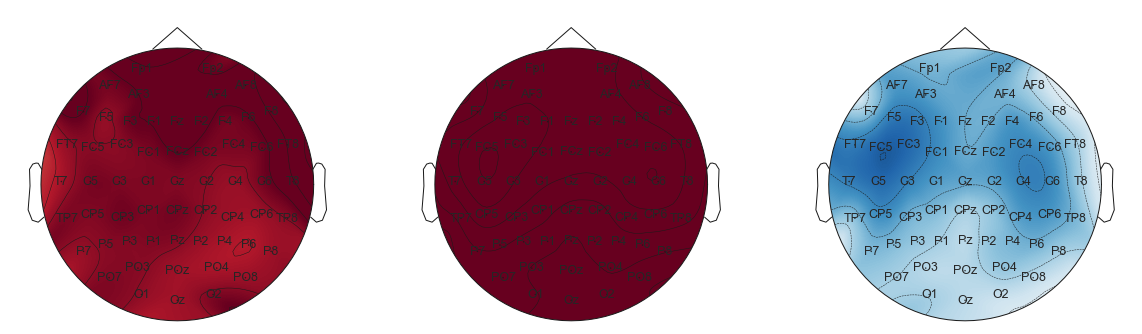

In [66]:
#
freq=2.5
vmin=-0.03

dataM=data.reset_index()
S = dataM[(dataM['Condition']=='All') & (dataM['Delay']==0) 
          & (dataM['Feature']=='envelop') & (dataM['Freq']==freq)]['Data'].get_values()
S = np.stack(S).mean(axis=0)

L = dataM[(dataM['Condition']=='All') & (dataM['Delay']==0) 
          & (dataM['Feature']=='lipaparature') & (dataM['Freq']==freq)]['Data'].get_values()
L = np.stack(L).mean(axis=0)

vmax=-vmin

f, ax = plt.subplots(figsize=(20,8))
a=plt.subplot(1, 3, 1)
mne.viz.plot_topomap(S, info.info,cmap='RdBu_r',vmin=vmin,vmax=vmax,axes=a,show=False,show_names=True,names=info.ch_names)
b=plt.subplot(1, 3, 2)
mne.viz.plot_topomap(L, info.info,cmap='RdBu_r',vmin=vmin,vmax=vmax,axes=b,show=False,show_names=True,names=info.ch_names)
c=plt.subplot(1, 3, 3)
mne.viz.plot_topomap(S-L, info.info,cmap='RdBu_r',vmin=vmin,vmax=vmax,axes=c,show=False,show_names=True,names=info.ch_names)

In [119]:
save_path = data_path + '/data/paper/lip-envelop_2.5Hz_cluster_permutation.pkl'
df.to_pickle(save_path)

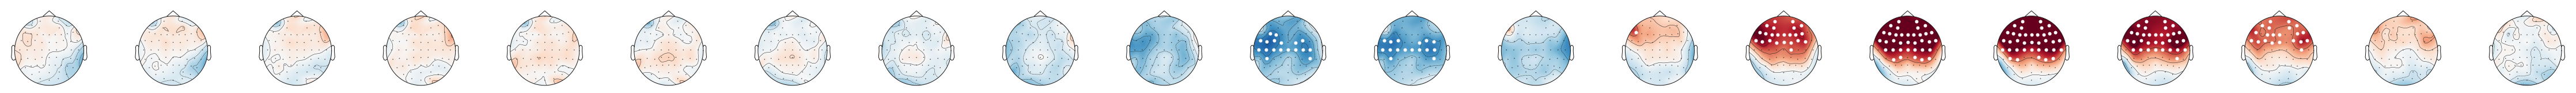

In [67]:
#
def plot_topo_image(df,vmin,vmax,typeF,cmap):
    fg = sns.FacetGrid(df,col=typeF)
    b = fg.map_dataframe(draw_heatmap, 'Data')
    b = b.set_xlabels('')
    b = b.set_titles('')
    #b.fig.subplots_adjust(top=0.7)
    #b.fig.subplots_adjust(right=0.8)
    #cbar_ax = b.fig.add_axes([0.82,0.25,0.01,0.45]) # [left, bottom, width, height] 
    #norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
    #sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    #sm.set_array([])
    #plt.colorbar(sm, ticks=np.linspace(vmin,vmax,5),cax=cbar_ax,label='Coherence')
    

def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    x = data['Data'].any() 
    if 'mask' in data:
        mask = data['mask'].any()
        mne.viz.plot_topomap(x, info.info, show=False,vmin=vmin,vmax=vmax,mask = mask,
                            mask_params = dict(marker='o', markerfacecolor='w', 
                                               markeredgecolor='w',linewidth=0, 
                                               markersize=5))
    else:
        mne.viz.plot_topomap(x, info.info, show=False,vmin=vmin,vmax=vmax)


delay = np.arange(-5,6) / 10
delay = np.arange(-5,5.5,0.5) / 10

aa = df.loc[df['Delay'].isin(delay)]
A = np.vstack(aa['Data'].get_values())
vmin = np.round(A.min(),decimals=2)
vmax = np.round(A.max(),decimals=2)  
vmin = -0.03
vmax = 0.03
plot_topo_image(aa,vmin,vmax,'Delay','Reds')  

(<matplotlib.image.AxesImage at 0x1682fb70>,
 <matplotlib.contour.QuadContourSet at 0x1682fd68>)

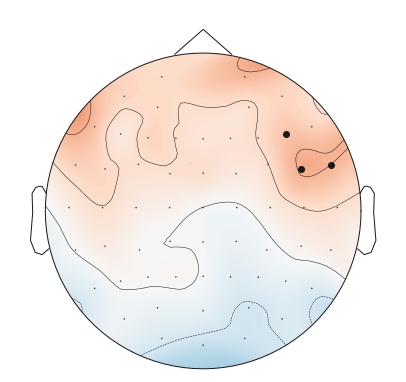

In [62]:
# paper figure
delay = [0.45]
aa = df[df['Delay'].isin(delay)]
x = aa['Data'].get_values()[0]
mask  = aa['mask'].get_values()[0]


vmin = np.round(x.min(),decimals=4)
vmax = np.round(x.max(),decimals=4) 

vmin=-0.035
vmax=-vmin


f, AX = plt.subplots(figsize=(18,6))


mne.viz.plot_topomap(x, info.info, show=False,vmin=vmin,vmax=vmax,mask = mask,cmap = 'RdBu_r',
                        mask_params = dict(marker='o', markerfacecolor='k', markeredgecolor='k',
     linewidth=0, markersize=6))


In [65]:
vmin

-0.0038

In [17]:
# partial coherence
save_path = data_path + '/data/partialCoh/PartialCoh-removedFirst-0.5-2-multitaper3cycle-1-40.5Hz-0.5step.pkl'

data=pd.read_pickle(save_path)
a  = data['Data'].apply(lambda x: np.mean(x))
data['partialCoh'] = pd.Series(a, index=data.index)
a = data.reset_index()
df = pd.DataFrame(np.column_stack(list(zip(*a.Data))), columns=info.ch_names)
data = pd.concat([a,df], axis=1)
data.set_index(['Feature','FeatureDelay','RemoveFeature','RemoveFeatureDelay',
                        'Freq','Condition','Subject'], inplace=True)
data.sort_index(inplace=True)



In [14]:
# data partial coherence merge data with jonluca
# frequency estimation with 1hz step
save_path = data_path + '/data/partialCoh/PartialCoh-removedFirst-0.5-2-multitaper3cycle-1-40.5Hz-0.5step_additinalSegments.pkl'

data_part=pd.read_pickle(save_path)


a  = data_part['Data'].apply(lambda x: np.mean(x))
data_part['partialCoh'] = pd.Series(a, index=data_part.index)
a = data_part.reset_index()
df = pd.DataFrame(np.column_stack(list(zip(*a.Data))), columns=info.ch_names)
data_part = pd.concat([a,df], axis=1)
data_part.set_index(['Feature','FeatureDelay','RemoveFeature','RemoveFeatureDelay',
                        'Freq','Condition','Subject'], inplace=True)
data_part.sort_index(inplace=True)

features = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']
condition = ['All']
fr = np.arange(1.5,13,0.5)
delay = np.arange(-5,5.5,0.5) / 10

a = data_part.loc[features,fr,condition,delay,'Jonluca']
Jonluca = a.reset_index()

# data coherence
# frequency estimation with 1hz step
save_path = data_path + '/data/partialCoh/PartialCoh-removedFirst-0.5-2-multitaper3cycle-1-40.5Hz-0.5step.pkl'

data_part=pd.read_pickle(save_path)


a  = data_part['Data'].apply(lambda x: np.mean(x))
data_part['partialCoh'] = pd.Series(a, index=data_part.index)
a = data_part.reset_index()
df = pd.DataFrame(np.column_stack(list(zip(*a.Data))), columns=info.ch_names)
data_part = pd.concat([a,df], axis=1)
#data.set_index(['Feature','Freq','Condition','Delay','Subject'], inplace=True)
#data.sort_index(inplace=True)

DATA = data_part

# merge data

data_part = pd.concat([DATA, Jonluca])
data_part.set_index(['Feature','FeatureDelay','RemoveFeature','RemoveFeatureDelay',
                        'Freq','Condition','Subject'], inplace=True)
data_part.sort_index(inplace=True)

In [66]:
# surrogate partial coherence
save_path = data_path + '/data/partialCoh/PartialCoh-removedFirst-0.5-2-multitaper3cycle-1-40.5Hz-0.5step_additinalSegments_surrogate.pkl'
data_surrogate_part=pd.read_pickle(save_path)
a  = data_surrogate_part['Data'].apply(lambda x: np.mean(x))
data_surrogate_part['partialCoh'] = pd.Series(a, index=data_surrogate_part.index)
data_surrogate_part.set_index(['Feature','FeatureDelay','RemoveFeature','RemoveFeatureDelay',
                        'Freq','Condition','Subject'], inplace=True)
data_surrogate_part.sort_index(inplace=True)

(<matplotlib.image.AxesImage at 0x3d0a3828>,
 <matplotlib.contour.QuadContourSet at 0x3d0a3b00>)

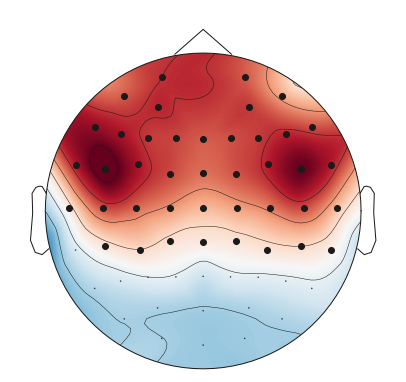

In [34]:
# get mask from filedtrip

def get_data_for_clusterpermutation(data1,data2,f1,f2,freq_band,condition,delay,subject_name):
    frame1 =[]
    frame2 =[]
    for d in delay:
        condition1 = []
        condition2 = []
        for s in subject_name:
            A = data1.loc[f1,d,f2,d,freq_band,condition,s]['Data'].get_values()
            B = data2.loc[f2,d,f1,d,freq_band,condition,s]['Data'].get_values()
            condition1.append(A[0])
            condition2.append(B[0])

        condition2 = np.asarray(condition2)
        condition1 = np.asarray(condition1)

        frame1.append(condition1)
        frame2.append(condition2)

    condition2 = np.asarray(frame2)
    condition1 = np.asarray(frame1)

    condition1 = np.swapaxes(condition1,0,1)
    condition2 = np.swapaxes(condition2,0,1)
    
    return condition1,condition2



freq_band = [2.5]
features = ['envelop','lipaparature']
delay = np.arange(-5,5.5,0.5) / 10
delay = [0.3]

condition1,condition2=get_data_for_clusterpermutation(data,data,features[0],features[1],
                                                      freq_band,condition,delay,subject_name)

A=np.mean(condition1-condition2,axis=0)


#
raw_fname = data_path + '/entrainment_python/2.5_0delay_pcoh_lip_envelop_mask.mat'
raw_fname = data_path + '/entrainment_python/2.5_0.3delay_pcoh_lip_envelop_mask.mat'

mat = scipy.io.loadmat(raw_fname)

mask = mat['mask']
mask = np.array(mask, dtype=bool)


frame = []
for d in range(0,len(delay)):
    df = pd.DataFrame({'mask':[mask[:,d]],'Data':[A[d,:]],'Delay':delay[d]})
    frame.append(df)
df = pd.concat((frame),axis=0)

vmin = np.round(min(A.flatten()),decimals=4)
vmax = np.round(max(A.flatten()),decimals=4)

vmin=-0.002
vmax=0.004


aa = df[df['Delay'].isin(delay)]
x = aa['Data'].get_values()[0]


f, AX = plt.subplots(figsize=(18,6))


mne.viz.plot_topomap(x, info.info, show=False,vmin=vmin,vmax=vmax,mask = mask,cmap = 'RdBu_r',
                        mask_params = dict(marker='o', markerfacecolor='k', markeredgecolor='k',
     linewidth=0, markersize=6))



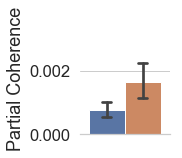

In [113]:
#
features = ['envelop','lipaparature']


freq_band = [2.5]
delay = [0]
freq = [ ' 1 - 4Hz']
freq = [ 'Delta']

a = data_part.loc[features,delay,features,delay,freq_band,condition,subject_name]['partialCoh']
a = pd.DataFrame(a.reset_index())

#f, AX = plt.subplots(figsize=(15,6))

#ax = sns.barplot(x="Freq", y="Coherence", hue="Feature", data=a,capsize=.2)
#ax.set_xticklabels(freq,rotation=0)
#ax.set_title('Delay '+ str(int(delay[0]*1000)) +' ms')
sns.set(font_scale=1.5)
sns.set_style("whitegrid")

g = sns.catplot(x="Freq", y="partialCoh", hue="Feature", data=a, col="FeatureDelay", 
                kind="bar", height=3, aspect=1,legend =False,
                capsize=.1)
g.set_xticklabels(freq,rotation=0)
g.despine(left=True)
g.set(ylim=(0, 0.0035))

g.set_titles('')
g.set_titles('')
g.set_xlabels('')
g.set_xticklabels('')
g.set_ylabels('Partial Coherence')
g.savefig('temp.png', transparent=True)


In [13]:
sns.set(font_scale=1)

freq_band = np.arange(1.5,13,0.5)
condition = ['All']
delay = np.arange(-5,5.5,0.5) / 10
features = ['envelop','lipaparature']

Text(0.5,1,'[envelop - lip] - [Lip - envelop ]')

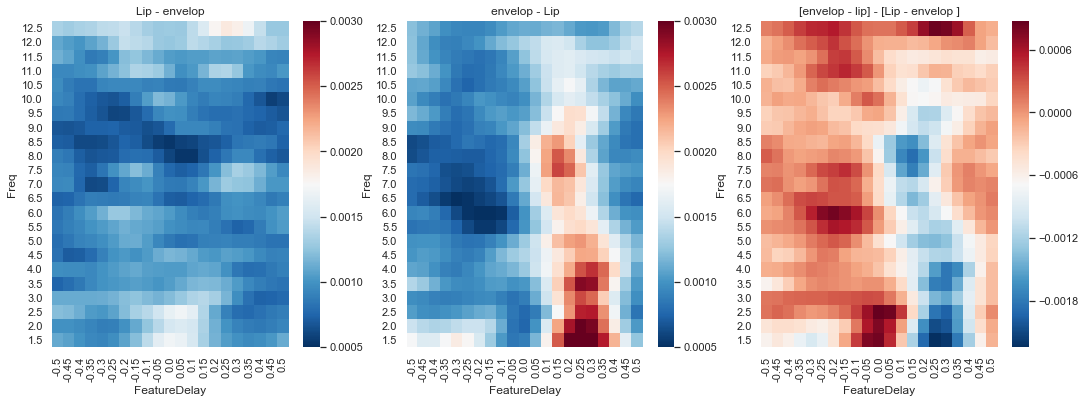

In [19]:
# freq delay heatmap for all features (partial coherence)
A = data.loc[features[0],delay,features[1],delay,freq_band,condition,subject_name]['partialCoh']
A = A.reset_index()
b = A.groupby(['Feature','FeatureDelay','RemoveFeature','RemoveFeatureDelay','Freq'])['partialCoh'].mean().reset_index()

A = data.loc[features[1],delay,features[0],delay,freq_band,condition,subject_name]['partialCoh']
A = A.reset_index()
a = A.groupby(['Feature','FeatureDelay','RemoveFeature','RemoveFeatureDelay','Freq'])['partialCoh'].mean().reset_index()


x=a.copy()
x['partialCoh'] = a['partialCoh'].get_values() - b['partialCoh'].get_values()

a = pd.DataFrame(a)
a = a.pivot(index="Freq", columns="FeatureDelay", values="partialCoh")
b = pd.DataFrame(b)
b = b.pivot(index="Freq", columns="FeatureDelay", values="partialCoh")
x = pd.DataFrame(x)
x = x.pivot(index="Freq", columns="FeatureDelay", values="partialCoh")

cmap='RdBu_r'
f, AX = plt.subplots(figsize=(18,6))
plt.subplot(1,3,1)
ax = sns.heatmap(a,vmin=0.0005,vmax=0.003,cmap = cmap)
ax.invert_yaxis()
plt.title('Lip - envelop')

plt.subplot(1,3,2)
ax = sns.heatmap(b,vmin=0.0005,vmax=0.003,cmap = cmap)
ax.invert_yaxis()
plt.title('envelop - Lip')

plt.subplot(1,3,3)
ax = sns.heatmap(x, cmap = cmap)
ax.invert_yaxis()
plt.title('[envelop - lip] - [Lip - envelop ]')



Text(0.5,1,'[envelop - lip] - [Lip - envelop ] (surrogate)')

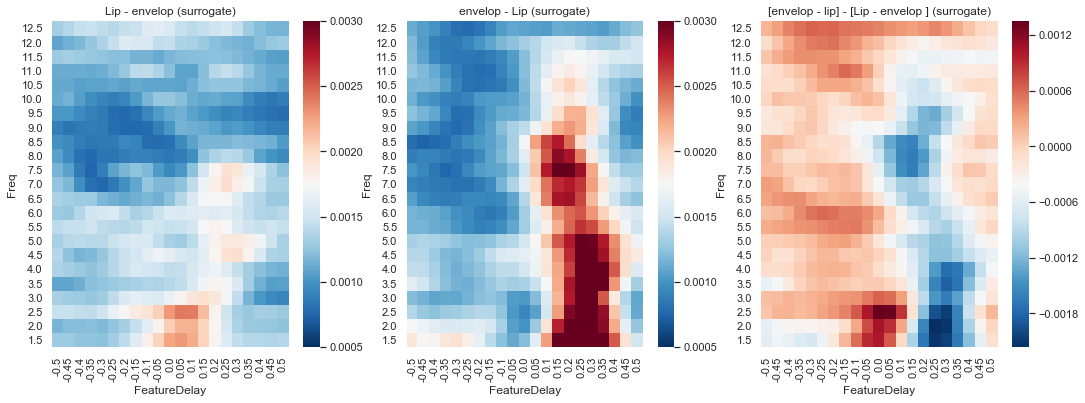

In [18]:
# freq delay heatmap for all features (surrogate partial coherence)
A = data_surrogate_part.loc[features[0],delay,features[1],delay,freq_band,condition,subject_name]['partialCoh']
A = A.reset_index()
b = A.groupby(['Feature','FeatureDelay','RemoveFeature','RemoveFeatureDelay','Freq'])['partialCoh'].mean().reset_index()

A = data_surrogate_part.loc[features[1],delay,features[0],delay,freq_band,condition,subject_name]['partialCoh']
A = A.reset_index()
a = A.groupby(['Feature','FeatureDelay','RemoveFeature','RemoveFeatureDelay','Freq'])['partialCoh'].mean().reset_index()


x=a.copy()
x['partialCoh'] = a['partialCoh'].get_values() - b['partialCoh'].get_values()

a = pd.DataFrame(a)
a = a.pivot(index="Freq", columns="FeatureDelay", values="partialCoh")
b = pd.DataFrame(b)
b = b.pivot(index="Freq", columns="FeatureDelay", values="partialCoh")
x = pd.DataFrame(x)
x = x.pivot(index="Freq", columns="FeatureDelay", values="partialCoh")

cmap='RdBu_r'
f, AX = plt.subplots(figsize=(18,6))
plt.subplot(1,3,1)
ax = sns.heatmap(a,vmin=0.0005,vmax=0.003,cmap = cmap)
ax.invert_yaxis()
plt.title('Lip - envelop (surrogate)')

plt.subplot(1,3,2)
ax = sns.heatmap(b,vmin=0.0005,vmax=0.003,cmap = cmap)
ax.invert_yaxis()
plt.title('envelop - Lip (surrogate)')

plt.subplot(1,3,3)
ax = sns.heatmap(x, cmap = cmap)
ax.invert_yaxis()
plt.title('[envelop - lip] - [Lip - envelop ] (surrogate)')



Text(0.5,1,'Lip - envelop (surrogate)')

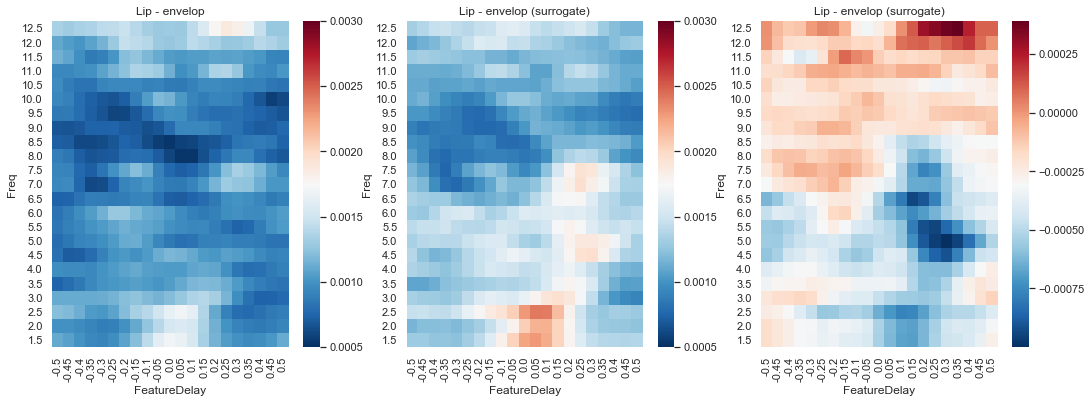

In [16]:
# partial coherence original and surrogate

A = data.loc[features[1],delay,features[0],delay,freq_band,condition,subject_name]['partialCoh']
A = A.reset_index()
a = A.groupby(['Feature','FeatureDelay','RemoveFeature','RemoveFeatureDelay','Freq'])['partialCoh'].mean().reset_index()

A = data_surrogate_part.loc[features[1],delay,features[0],delay,freq_band,condition,subject_name]['partialCoh']
A = A.reset_index()
b = A.groupby(['Feature','FeatureDelay','RemoveFeature','RemoveFeatureDelay','Freq'])['partialCoh'].mean().reset_index()


x=a.copy()
x['partialCoh'] = a['partialCoh'].get_values() - b['partialCoh'].get_values()


a = pd.DataFrame(a)
a = a.pivot(index="Freq", columns="FeatureDelay", values="partialCoh")
b = pd.DataFrame(b)
b = b.pivot(index="Freq", columns="FeatureDelay", values="partialCoh")
x = pd.DataFrame(x)
x = x.pivot(index="Freq", columns="FeatureDelay", values="partialCoh")

cmap='RdBu_r'
f, AX = plt.subplots(figsize=(18,6))
plt.subplot(1,3,1)
ax = sns.heatmap(a,vmin=0.0005,vmax=0.003,cmap = cmap)
ax.invert_yaxis()
plt.title('Lip - envelop')

plt.subplot(1,3,2)
ax = sns.heatmap(b,vmin=0.0005,vmax=0.003,cmap = cmap)
ax.invert_yaxis()
plt.title('Lip - envelop (surrogate)')


plt.subplot(1,3,3)
ax = sns.heatmap(x, cmap = cmap)
ax.invert_yaxis()
plt.title('Lip - envelop (surrogate)')



Text(0.5,1,'[envelop - lip] - [Lip - envelop ]  (surrogate)')

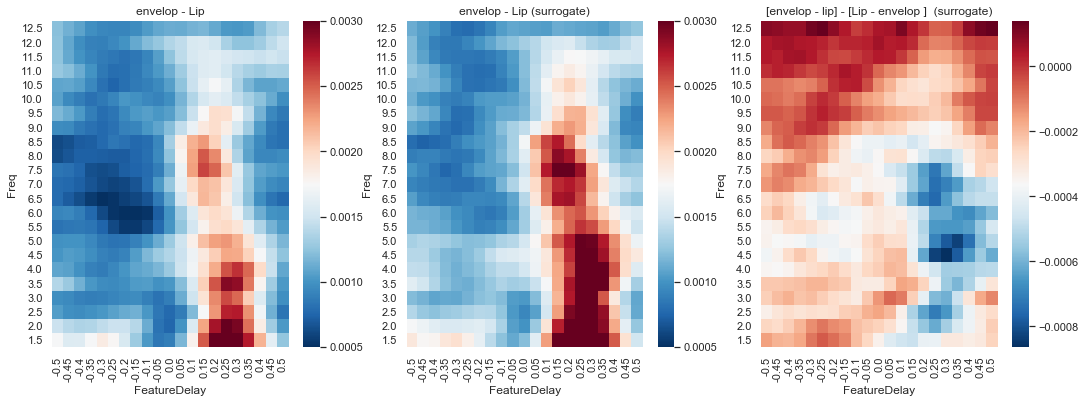

In [20]:
# partial coherence original and surrogate

A = data.loc[features[0],delay,features[1],delay,freq_band,condition,subject_name]['partialCoh']
A = A.reset_index()
a = A.groupby(['Feature','FeatureDelay','RemoveFeature','RemoveFeatureDelay','Freq'])['partialCoh'].mean().reset_index()

A = data_surrogate_part.loc[features[0],delay,features[1],delay,freq_band,condition,subject_name]['partialCoh']
A = A.reset_index()
b = A.groupby(['Feature','FeatureDelay','RemoveFeature','RemoveFeatureDelay','Freq'])['partialCoh'].mean().reset_index()


x=a.copy()
x['partialCoh'] = a['partialCoh'].get_values() - b['partialCoh'].get_values()


a = pd.DataFrame(a)
a = a.pivot(index="Freq", columns="FeatureDelay", values="partialCoh")
b = pd.DataFrame(b)
b = b.pivot(index="Freq", columns="FeatureDelay", values="partialCoh")
x = pd.DataFrame(x)
x = x.pivot(index="Freq", columns="FeatureDelay", values="partialCoh")

cmap='RdBu_r'
f, AX = plt.subplots(figsize=(18,6))
plt.subplot(1,3,1)
ax = sns.heatmap(a,vmin=0.0005,vmax=0.003,cmap = cmap)
ax.invert_yaxis()
plt.title('envelop - Lip')

plt.subplot(1,3,2)
ax = sns.heatmap(b,vmin=0.0005,vmax=0.003,cmap = cmap)
ax.invert_yaxis()
plt.title('envelop - Lip (surrogate)')


plt.subplot(1,3,3)
ax = sns.heatmap(x, cmap = cmap)
ax.invert_yaxis()
plt.title('[envelop - lip] - [Lip - envelop ]  (surrogate)')



C:\Users\EspVicon\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\EspVicon\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


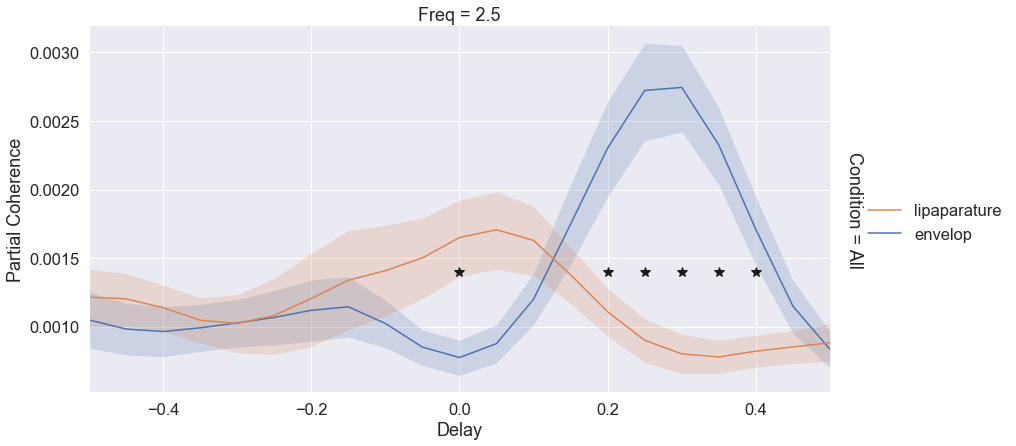

In [12]:
# partial coherence delay avg coherence features plot
features = ['envelop','lipaparature']
Removedfeatures = ['envelop','lipaparature']
delay = np.arange(-5,5.5,0.5) / 10
freq = [2.5]


#sig_lip_ch = ['FC5', 'T7', 'CP5', 'F5', 'FC3', 'C5']


# stat
P = get_P_value_Partial(data,features,freq,condition,delay,subject_name)
a = fdr_correction(P['p-value'].get_values(), alpha=0.05, method='indep')
P['FDRp-value'] = a[1]
x = P[P['FDRp-value'] <= 0.05]['Delay'].get_values()
y = np.repeat(0.0014,len(x))

plot_delayTimeCoursePartial(data,features,Removedfeatures,delay,freq,subject_name)
x = plt.plot(x,y, marker='*', color='k',markersize=10,linestyle='')


In [13]:
a

(array([False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False,  True,  True,  True,  True,
         True, False, False]),
 array([0.8512    , 0.81576923, 0.831     , 0.96931579, 0.99      ,
        0.99      , 0.96931579, 0.9384375 , 0.7105    , 0.231     ,
        0.0385    , 0.066     , 0.5628    , 0.7105    , 0.0385    ,
        0.        , 0.        , 0.        , 0.0385    , 0.53433333,
        0.96931579]))

Could not find a connectivity matrix for the data. Computing connectivity based on Delaunay triangulations.
-- number of connected vertices : 59
stat_fun(H1): min=0.000000 max=35.037435
Running initial clustering
Using 176 thresholds from 0.00 to 35.00 for TFCE computation (h_power=2.00, e_power=0.50)
Found 590 clusters
Permuting 999 times...


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   2 out of   7 | elapsed:   17.9s remaining:   45.0s
[Parallel(n_jobs=7)]: Done   4 out of   7 | elapsed:   18.1s remaining:   13.5s


Computing cluster p-values
Done.


[Parallel(n_jobs=7)]: Done   7 out of   7 | elapsed:   18.7s finished


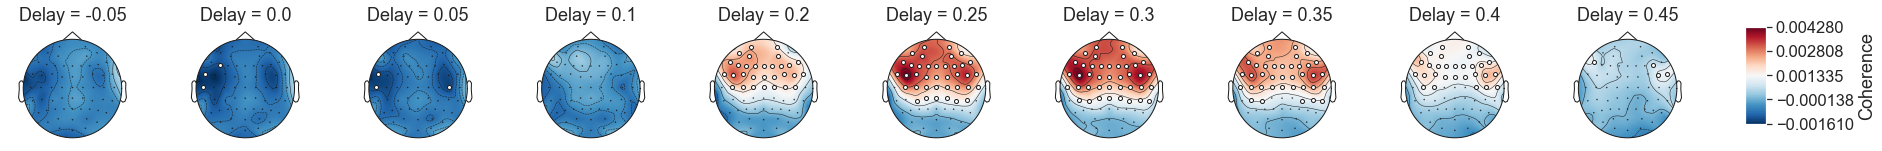

In [79]:
# cluster permutaitation  (between features)

def compute_cluster_permutation_coherence_features(condition1,condition2):
    fname = os.path.dirname(os.path.dirname(os.getcwd())) + '/fieldtrip_eeg_clean\mat/acticap-64ch-standard2_ferrara_neighb_for_mne.mat'
    connectivity ,ch_names = mne.channels.read_ch_connectivity(fname)
    connectivity ,ch_names = mne.channels.find_ch_connectivity(info.info,'eeg')
    
    stat_fun_hat = partial(ttest_1samp_no_p, sigma=1e-3)       
    threshold_tfce = dict(start=0, step=0.2)
    p_threshold = 0.025
    #threshold_tfce = -stats.distributions.t.ppf(p_threshold / 2., condition1.shape[0] - 1)
   
    T, clusters, cluster_p_values, H0 = mne.stats.spatio_temporal_cluster_test([condition1,condition2],n_permutations=1000, 
                                                                 connectivity = connectivity,
                                                                           #stat_fun=stat_fun_hat,
                                                                           #check_disjoint =True,
                                                                       threshold=threshold_tfce, 
                                                                                     #step_down_p =0.05,
                                                                                     #max_step = 2,
                                                                               tail=0,
                                                                               n_jobs =7     )

    T_obs_plot = np.nan * np.ones_like(T)
    for c, p_val in zip(clusters, cluster_p_values):
        if p_val <= 0.025:
            T_obs_plot[c] = T[c]

    mask = np.invert(np.isnan(T_obs_plot))
    return T, mask

def get_data_for_clusterpermutation(data1,data2,f1,f2,freq_band,condition,delay,subject_name):
    frame1 =[]
    frame2 =[]
    for d in delay:
        condition1 = []
        condition2 = []
        for s in subject_name:
            A = data1.loc[f1,d,f2,d,freq_band,condition,s]['Data'].get_values()
            B = data2.loc[f2,d,f1,d,freq_band,condition,s]['Data'].get_values()
            condition1.append(A[0])
            condition2.append(B[0])

        condition2 = np.asarray(condition2)
        condition1 = np.asarray(condition1)

        frame1.append(condition1)
        frame2.append(condition2)

    condition2 = np.asarray(frame2)
    condition1 = np.asarray(frame1)

    condition1 = np.swapaxes(condition1,0,1)
    condition2 = np.swapaxes(condition2,0,1)
    
    return condition1,condition2



freq_band = [2.5]
features = ['envelop','lipaparature']
delay = np.arange(-5,5.5,0.5) / 10
delay = [-0.05,0,0.05,0.1,0.2,0.25,0.3,0.35,0.4,0.45]

condition1,condition2=get_data_for_clusterpermutation(data,data,features[0],features[1],
                                                      freq_band,condition,delay,subject_name)

T, mask = compute_cluster_permutation_coherence_features(condition1,condition2)
A=np.mean(condition1-condition2,axis=0)
frame = []
for d in range(0,len(delay)):
    df = pd.DataFrame({'mask':[mask[d,:]],'Data':[A[d,:]],'Delay':delay[d]})
    frame.append(df)
df = pd.concat((frame),axis=0)

vmin = np.round(min(A.flatten()),decimals=5)
vmax = np.round(max(A.flatten()),decimals=5)
plot_topo_image(df,vmin,vmax,'Delay','RdBu_r')

In [96]:
# best channel find of features
features = ['envelop']
#features = ['lipaparature']

ch = np.asarray(info.ch_names)
delay = np.arange(-5,5.5,0.5) / 10
freq = [2.5]
A = []
for d in delay:
    a = data.loc[features,freq,condition,d,subject_name][info.ch_names].get_values()
    a = np.mean(a,axis=0)
    A.append(a)

A = np.asarray(A)

a = np.argmax(A,axis=1)
b = np.max(A,axis=1)

aa=pd.DataFrame({'Channel':ch[a],'Delay':delay,'max':b})
ch[np.argmax(np.mean(A,axis=0))]

'FC6'

In [8]:
features = ['envelop','lipaparature']
ch1='FC6'

a = data.loc[features,freq,condition,delay,subject_name][ch1]
a = a.reset_index()
g = sns.FacetGrid(a, col="Freq", row="Condition",margin_titles=True,size=6,aspect=2)
b = g.map_dataframe(sns.tsplot, time="Delay", unit="Subject",condition="Feature", 
                    value=ch1,color="deep",err_style='ci_band').add_legend()
b = b.set_xlabels('Delay')
b = b.set_ylabels('Coherence')

C:\Users\EspVicon\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


ValueError: left cannot be >= right

<Figure size 13.2x0 with 0 Axes>

C:\Users\EspVicon\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\EspVicon\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


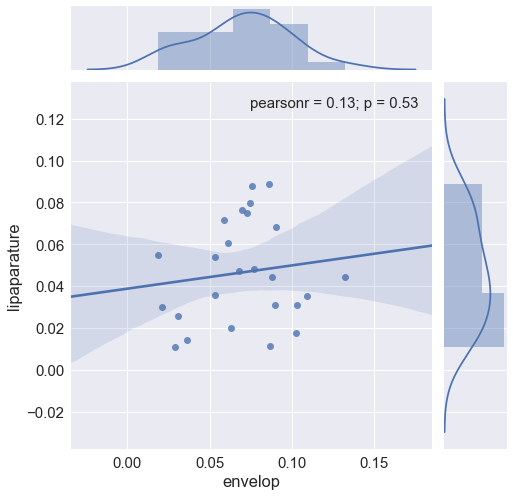

In [6]:
# single subject coherence

features = ['envelop','lipaparature']

ch1='FC6'
a = data.loc[features[0],2.5,condition,0.25,subject_name][ch1].get_values()
b = data.loc[features[1],2.5,condition,0.05,subject_name][ch1].get_values()

df = pd.DataFrame({features[0]:a,'Subject':subject_name,features[1]:b,})

sns.jointplot(features[0],features[1], data=df, kind="reg", size=7)

In [4]:
# single trial coherence
save_path = data_path + '/data/coherence/coh-multitaper3cycle-1-40.5Hz-0.5step-adaptiveFalse-trialwise_lipaparature_envelop.pkl'
data=pd.read_pickle(save_path)

data.set_index(['Feature','Freq','Condition','Delay','Subject'], inplace=True)
data.sort_index(inplace=True)


In [ ]:
# single trial coherence plot

features = ['envelop','lipaparature']

ch1='FC6'
ch1 = info.ch_names.index(ch1)

a = data.loc[features[0],2.5,condition,0.2,subject_name]['Data'].get_values()
a1 = data.loc[features[0],2.5,condition,0.25,subject_name]['condIDX'].get_values()

b = data.loc[features[1],2.5,condition,0.,subject_name]['Data'].get_values()

A=[]
B=[]
A1=[]
for s in range(0,len(subject_name)):
    A = np.hstack((A,a[s][:,ch1].T))
    A1 = np.hstack((A1,a1[s].T))
    B = np.hstack((B,b[s][:,ch1].T))

A = np.asarray(A)
B = np.asarray(B)
A1 = np.asarray(A1)

df = pd.DataFrame({features[0]:A,features[1]:B,'condition':A1})

sns.jointplot(features[0],features[1], data=df, kind="reg", size=7, order=1)

C:\Users\EspVicon\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\EspVicon\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


C:\Users\EspVicon\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\EspVicon\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\EspVicon\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\EspVicon\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\EspVicon\Anaconda3\lib\site-packages\matplotlib

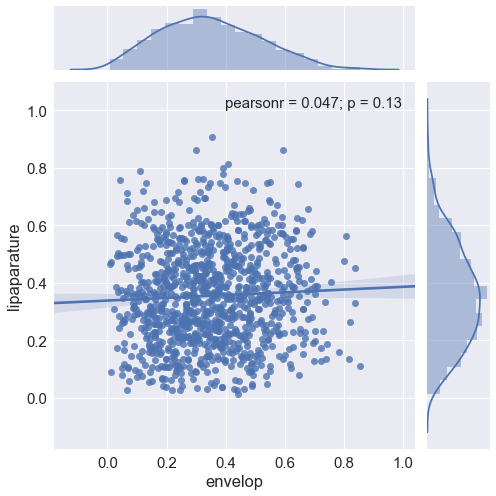

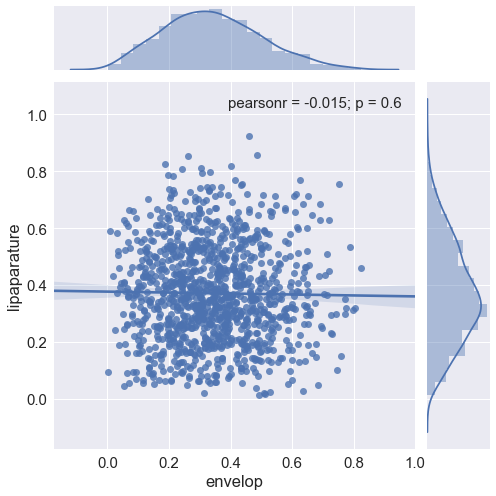

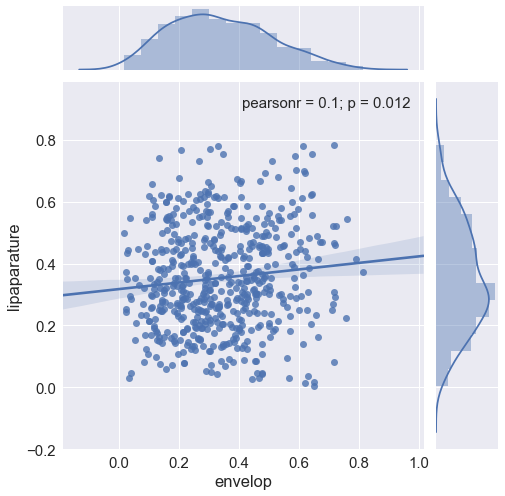

In [51]:
# single trial coherence seperate condiiton hyper normal hypo
a=df.loc[df['condition']==1.0]
sns.jointplot(features[0],features[1], data=a, kind="reg", size=7, order=1)
a=df.loc[df['condition']==2.0]
sns.jointplot(features[0],features[1], data=a, kind="reg", size=7, order=1)
a=df.loc[df['condition']==3.0]
sns.jointplot(features[0],features[1], data=a, kind="reg", size=7, order=1)